# Homework Description
- English to Chinese (Traditional) Translation
  - Input: an English sentence         (e.g.		tom is a student .)
  - Output: the Chinese translation  (e.g. 		湯姆 是 個 學生 。)

- TODO
    - Train a simple RNN seq2seq to acheive translation
    - Switch to transformer model to boost performance
    - Apply Back-translation to furthur boost performance

In [1]:
# !nvidia-smi

# Download and import required packages

In [2]:
# !pip install 'torch>=1.6.0' editdistance matplotlib sacrebleu sacremoses sentencepiece tqdm wandb
# !pip install --upgrade jupyter ipywidgets

In [3]:
# !git clone https://github.com/pytorch/fairseq.git
# !cd fairseq && git checkout 9a1c497
# !pip install --upgrade ./fairseq/

In [1]:
import sys
import pdb
import pprint
import logging
import os
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
import numpy as np
import tqdm.auto as tqdm
from pathlib import Path
from argparse import Namespace
from fairseq import utils

import matplotlib.pyplot as plt

# Fix random seed

In [2]:
seed = 666
random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  
np.random.seed(seed)  
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

# Dataset

## En-Zh Bilingual Parallel Corpus
* [TED2020](#reimers-2020-multilingual-sentence-bert)
    - Raw: 398,066 (sentences)   
    - Processed: 393,980 (sentences)
    

## Testdata
- Size: 4,000 (sentences)
- **Chinese translation is undisclosed. The provided (.zh) file is psuedo translation, each line is a '。'**

## Dataset Download

In [6]:
data_dir = './DATA/rawdata'
dataset_name = 'ted2020'
# urls = (
#     "https://github.com/yuhsinchan/ML2022-HW5Dataset/releases/download/v1.0.2/ted2020.tgz",
#     "https://github.com/yuhsinchan/ML2022-HW5Dataset/releases/download/v1.0.2/test.tgz",
# )
# file_names = (
#     'ted2020.tgz', # train & dev
#     'test.tgz', # test
# )
prefix = Path(data_dir).absolute() / dataset_name

prefix.mkdir(parents=True, exist_ok=True)
# for u, f in zip(urls, file_names):
#     path = prefix/f
#     if not path.exists():
#         !wget {u} -O {path}
#     if path.suffix == ".tgz":
#         !tar -xvf {path} -C {prefix}
#     elif path.suffix == ".zip":
#         !unzip -o {path} -d {prefix}
# !mv {prefix/'raw.en'} {prefix/'train_dev.raw.en'}
# !mv {prefix/'raw.zh'} {prefix/'train_dev.raw.zh'}
# !mv {prefix/'test/test.en'} {prefix/'test.raw.en'}
# !mv {prefix/'test/test.zh'} {prefix/'test.raw.zh'}
# !rm -rf {prefix/'test'}

## Language

In [7]:
# train a zh to en model for back translation
src_lang = 'zh'
tgt_lang = 'en'

data_prefix = f'{prefix}/train_dev.raw'
test_prefix = f'{prefix}/test.raw'

In [8]:
!head {data_prefix+'.'+src_lang} -n 5
!head {data_prefix+'.'+tgt_lang} -n 5

非常謝謝你，克里斯。能有這個機會第二度踏上這個演講台
真是一大榮幸。我非常感激。
這個研討會給我留下了極為深刻的印象，我想感謝大家 對我之前演講的好評。
我是由衷的想這麼說，有部份原因是因為 —— 我真的有需要!
請你們設身處地為我想一想！
Thank you so much, Chris.
And it's truly a great honor to have the opportunity to come to this stage twice; I'm extremely grateful.
I have been blown away by this conference, and I want to thank all of you for the many nice comments about what I had to say the other night.
And I say that sincerely, partly because  I need that.
Put yourselves in my position.


## Preprocess files

In [9]:
import re

def strQ2B(ustring):
    """Full width -> half width"""
    # reference:https://ithelp.ithome.com.tw/articles/10233122
    ss = []
    for s in ustring:
        rstring = ""
        for uchar in s:
            inside_code = ord(uchar)
            if inside_code == 12288:  # Full width space: direct conversion
                inside_code = 32
            elif (inside_code >= 65281 and inside_code <= 65374):  # Full width chars (except space) conversion
                inside_code -= 65248
            rstring += chr(inside_code)
        ss.append(rstring)
    return ''.join(ss)
                
def clean_s(s, lang):
    if lang == 'en':
        s = re.sub(r"\([^()]*\)", "", s) # remove ([text])
        s = s.replace('-', '') # remove '-'
        s = re.sub('([.,;!?()\"])', r' \1 ', s) # keep punctuation
    elif lang == 'zh':
        s = strQ2B(s) # Q2B
        s = re.sub(r"\([^()]*\)", "", s) # remove ([text])
        s = s.replace(' ', '')
        s = s.replace('—', '')
        s = s.replace('“', '"')
        s = s.replace('”', '"')
        s = s.replace('_', '')
        s = re.sub('([。,;!?()\"~「」])', r' \1 ', s) # keep punctuation
    s = ' '.join(s.strip().split())
    return s

def len_s(s, lang):
    if lang == 'zh':
        return len(s)
    return len(s.split())

def clean_corpus(prefix, l1, l2, ratio=9, max_len=1000, min_len=1):
    if Path(f'{prefix}.clean.{l1}').exists() and Path(f'{prefix}.clean.{l2}').exists():
        print(f'{prefix}.clean.{l1} & {l2} exists. skipping clean.')
        return
    with open(f'{prefix}.{l1}', 'r') as l1_in_f:
        with open(f'{prefix}.{l2}', 'r') as l2_in_f:
            with open(f'{prefix}.clean.{l1}', 'w') as l1_out_f:
                with open(f'{prefix}.clean.{l2}', 'w') as l2_out_f:
                    for s1 in l1_in_f:
                        s1 = s1.strip()
                        s2 = l2_in_f.readline().strip()
                        s1 = clean_s(s1, l1)
                        s2 = clean_s(s2, l2)
                        s1_len = len_s(s1, l1)
                        s2_len = len_s(s2, l2)
                        if min_len > 0: # remove short sentence
                            if s1_len < min_len or s2_len < min_len:
                                continue
                        if max_len > 0: # remove long sentence
                            if s1_len > max_len or s2_len > max_len:
                                continue
                        if ratio > 0: # remove by ratio of length
                            if s1_len/s2_len > ratio or s2_len/s1_len > ratio:
                                continue
                        print(s1, file=l1_out_f)
                        print(s2, file=l2_out_f)

In [10]:
clean_corpus(data_prefix, src_lang, tgt_lang)
clean_corpus(test_prefix, src_lang, tgt_lang, ratio=-1, min_len=-1, max_len=-1)

/home/tracy/Projects/ML2022/hw5/DATA/rawdata/ted2020/train_dev.raw.clean.zh & en exists. skipping clean.
/home/tracy/Projects/ML2022/hw5/DATA/rawdata/ted2020/test.raw.clean.zh & en exists. skipping clean.


In [11]:
!head {data_prefix+'.clean.'+src_lang} -n 5
!head {data_prefix+'.clean.'+tgt_lang} -n 5

非常謝謝你 , 克里斯 。 能有這個機會第二度踏上這個演講台
真是一大榮幸 。 我非常感激 。
這個研討會給我留下了極為深刻的印象 , 我想感謝大家對我之前演講的好評 。
我是由衷的想這麼說 , 有部份原因是因為我真的有需要 !
請你們設身處地為我想一想 !
Thank you so much , Chris .
And it's truly a great honor to have the opportunity to come to this stage twice ; I'm extremely grateful .
I have been blown away by this conference , and I want to thank all of you for the many nice comments about what I had to say the other night .
And I say that sincerely , partly because I need that .
Put yourselves in my position .


## Split into train/valid

In [12]:
valid_ratio = 0.01 # 3000~4000 would suffice
train_ratio = 1 - valid_ratio

In [13]:
if (prefix/f'train.clean.{src_lang}').exists() \
and (prefix/f'train.clean.{tgt_lang}').exists() \
and (prefix/f'valid.clean.{src_lang}').exists() \
and (prefix/f'valid.clean.{tgt_lang}').exists():
    print(f'train/valid splits exists. skipping split.')
else:
    line_num = sum(1 for line in open(f'{data_prefix}.clean.{src_lang}'))
    labels = list(range(line_num))
    random.shuffle(labels)
    for lang in [src_lang, tgt_lang]:
        train_f = open(os.path.join(data_dir, dataset_name, f'train.clean.{lang}'), 'w')
        valid_f = open(os.path.join(data_dir, dataset_name, f'valid.clean.{lang}'), 'w')
        count = 0
        for line in open(f'{data_prefix}.clean.{lang}', 'r'):
            if labels[count]/line_num < train_ratio:
                train_f.write(line)
            else:
                valid_f.write(line)
            count += 1
        train_f.close()
        valid_f.close()

train/valid splits exists. skipping split.


## Subword Units 
Out of vocabulary (OOV) has been a major problem in machine translation. This can be alleviated by using subword units.
- We will use the [sentencepiece](#kudo-richardson-2018-sentencepiece) package
- select 'unigram' or 'byte-pair encoding (BPE)' algorithm

In [14]:
import sentencepiece as spm
vocab_size = 8000
if (prefix/f'spm{vocab_size}.model').exists():
    print(f'{prefix}/spm{vocab_size}.model exists. skipping spm_train.')
else:
    spm.SentencePieceTrainer.train(
        input=','.join([f'{prefix}/train.clean.{src_lang}',
                        f'{prefix}/valid.clean.{src_lang}',
                        f'{prefix}/train.clean.{tgt_lang}',
                        f'{prefix}/valid.clean.{tgt_lang}']),
        model_prefix=prefix/f'spm{vocab_size}',
        vocab_size=vocab_size,
        character_coverage=1,
        model_type='unigram', # 'bpe' works as well
        input_sentence_size=1e6,
        shuffle_input_sentence=True,
        normalization_rule_name='nmt_nfkc_cf',
    )

/home/tracy/Projects/ML2022/hw5/DATA/rawdata/ted2020/spm8000.model exists. skipping spm_train.


In [15]:
spm_model = spm.SentencePieceProcessor(model_file=str(prefix/f'spm{vocab_size}.model'))
in_tag = {
    'train': 'train.clean',
    'valid': 'valid.clean',
    'test': 'test.raw.clean',
}
for split in ['train', 'valid', 'test']:
    for lang in [src_lang, tgt_lang]:
        out_path = prefix/f'{split}.{lang}'
        if out_path.exists():
            print(f"{out_path} exists. skipping spm_encode.")
        else:
            with open(prefix/f'{split}.{lang}', 'w') as out_f:
                with open(prefix/f'{in_tag[split]}.{lang}', 'r') as in_f:
                    for line in in_f:
                        line = line.strip()
                        tok = spm_model.encode(line, out_type=str)
                        print(' '.join(tok), file=out_f)

/home/tracy/Projects/ML2022/hw5/DATA/rawdata/ted2020/train.zh exists. skipping spm_encode.
/home/tracy/Projects/ML2022/hw5/DATA/rawdata/ted2020/train.en exists. skipping spm_encode.
/home/tracy/Projects/ML2022/hw5/DATA/rawdata/ted2020/valid.zh exists. skipping spm_encode.
/home/tracy/Projects/ML2022/hw5/DATA/rawdata/ted2020/valid.en exists. skipping spm_encode.
/home/tracy/Projects/ML2022/hw5/DATA/rawdata/ted2020/test.zh exists. skipping spm_encode.
/home/tracy/Projects/ML2022/hw5/DATA/rawdata/ted2020/test.en exists. skipping spm_encode.


In [16]:
!head {data_dir+'/'+dataset_name+'/train.'+src_lang} -n 5
!head {data_dir+'/'+dataset_name+'/train.'+tgt_lang} -n 5

▁ 非常 謝 謝 你 ▁, ▁ 克 里 斯 ▁。 ▁ 能 有 這個 機會 第二 度 踏 上 這個 演講 台
▁ 真 是 一 大 榮 幸 ▁。 ▁我 非常 感 激 ▁。
▁這個 研 討 會 給我 留 下 了 極 為 深 刻 的 印 象 ▁, ▁我想 感 謝 大家 對我 之前 演講 的 好 評 ▁。
▁我 是由 衷 的 想 這麼 說 ▁, ▁有 部份 原因 是因為 我 真的 有 需要 ▁!
▁ 請 你們 設 身 處 地 為 我想 一 想 ▁!
▁thank ▁you ▁so ▁much ▁, ▁chris ▁.
▁and ▁it ' s ▁ t ru ly ▁a ▁great ▁ho n or ▁to ▁have ▁the ▁ op port un ity ▁to ▁come ▁to ▁this ▁st age ▁ t wi ce ▁; ▁i ' m ▁ex t re me ly ▁gr ate ful ▁.
▁i ▁have ▁been ▁ bl ow n ▁away ▁by ▁this ▁con fer ence ▁, ▁and ▁i ▁want ▁to ▁thank ▁all ▁of ▁you ▁for ▁the ▁many ▁ ni ce ▁ com ment s ▁about ▁what ▁i ▁had ▁to ▁say ▁the ▁other ▁night ▁.
▁and ▁i ▁say ▁that ▁since re ly ▁, ▁part ly ▁because ▁i ▁need ▁that ▁.
▁put ▁your s el ve s ▁in ▁my ▁po s ition ▁.


## Binarize the data with fairseq

In [17]:
binpath = Path('./DATA/data-bin', dataset_name)
if binpath.exists():
    print(binpath, "exists, will not overwrite!")
else:
    !python -m fairseq_cli.preprocess \
        --source-lang {src_lang}\
        --target-lang {tgt_lang}\
        --trainpref {prefix/'train'}\
        --validpref {prefix/'valid'}\
        --testpref {prefix/'test'}\
        --destdir {binpath}\
        --joined-dictionary\
        --workers 2

DATA/data-bin/ted2020 exists, will not overwrite!


# Configuration for experiments

In [18]:
# config a zh to en model for back translation

config = Namespace(
    datadir = "./DATA/data-bin/ted2020",
    savedir = "./checkpoints/zhToen",
    source_lang = "zh",
    target_lang = "en",
    
    # cpu threads when fetching & processing data.
    num_workers=2,  
    # batch size in terms of tokens. gradient accumulation increases the effective batchsize.
    max_tokens=8192,
    accum_steps=2,
    
    # the lr s calculated from Noam lr scheduler. you can tune the maximum lr by this factor.
    lr_factor=1.5,
    lr_warmup=4000,
    
    # clipping gradient norm helps alleviate gradient exploding
    clip_norm=1.0,
    
    # maximum epochs for training
    max_epoch=30,
    start_epoch=1,
    
    # beam size for beam search
    beam=5, 
    # generate sequences of maximum length ax + b, where x is the source length
    max_len_a=1.2, 
    max_len_b=10, 
    # when decoding, post process sentence by removing sentencepiece symbols and jieba tokenization.
    post_process = "sentencepiece",
    
    # checkpoints
    keep_last_epochs=5,
    resume=None, # if resume from checkpoint name (under config.savedir)
    
    # logging
    use_wandb=False,
)

# Logging
- logging package logs ordinary messages
- wandb logs the loss, bleu, etc. in the training process

In [19]:
logging.basicConfig(
    format="%(asctime)s | %(levelname)s | %(name)s | %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S",
    level="INFO", # "DEBUG" "WARNING" "ERROR"
    stream=sys.stdout,
)
proj = "hw5.seq2seq"
logger = logging.getLogger(proj)
if config.use_wandb:
    import wandb
    wandb.init(project=proj, name=Path(config.savedir).stem, config=config)

# CUDA Environments

In [3]:
cuda_env = utils.CudaEnvironment()
utils.CudaEnvironment.pretty_print_cuda_env_list([cuda_env])
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Dataloading

## We borrow the TranslationTask from fairseq
* used to load the binarized data created above
* well-implemented data iterator (dataloader)
* built-in task.source_dictionary and task.target_dictionary are also handy
* well-implemented beach search decoder

In [21]:
from fairseq.tasks.translation import TranslationConfig, TranslationTask

## setup task
task_cfg = TranslationConfig(
    data=config.datadir,
    source_lang=config.source_lang,
    target_lang=config.target_lang,
    train_subset="train",
    required_seq_len_multiple=8,
    dataset_impl="mmap",
    upsample_primary=1,
)
task = TranslationTask.setup_task(task_cfg)

2022-03-20 16:49:33 | INFO | fairseq.tasks.translation | [zh] dictionary: 8000 types
2022-03-20 16:49:33 | INFO | fairseq.tasks.translation | [en] dictionary: 8000 types


In [22]:
logger.info("loading data for epoch 1")
task.load_dataset(split="train", epoch=1, combine=True) # combine if you have back-translation data.
task.load_dataset(split="valid", epoch=1)

2022-03-20 16:49:33 | INFO | hw5.seq2seq | loading data for epoch 1
2022-03-20 16:49:33 | INFO | fairseq.data.data_utils | loaded 390,041 examples from: ./DATA/data-bin/ted2020/train.en-zh.zh
2022-03-20 16:49:33 | INFO | fairseq.data.data_utils | loaded 390,041 examples from: ./DATA/data-bin/ted2020/train.en-zh.en
2022-03-20 16:49:33 | INFO | fairseq.tasks.translation | ./DATA/data-bin/ted2020 train zh-en 390041 examples
2022-03-20 16:49:33 | INFO | fairseq.data.data_utils | loaded 3,939 examples from: ./DATA/data-bin/ted2020/valid.en-zh.zh
2022-03-20 16:49:33 | INFO | fairseq.data.data_utils | loaded 3,939 examples from: ./DATA/data-bin/ted2020/valid.en-zh.en
2022-03-20 16:49:33 | INFO | fairseq.tasks.translation | ./DATA/data-bin/ted2020 valid zh-en 3939 examples


In [23]:
sample = task.dataset("valid")[1]
pprint.pprint(sample)
pprint.pprint(
    "Source: " + \
    task.source_dictionary.string(
        sample['source'],
        config.post_process,
    )
)
pprint.pprint(
    "Target: " + \
    task.target_dictionary.string(
        sample['target'],
        config.post_process,
    )
)

{'id': 1,
 'source': tensor([ 140,  690,   28,  270,   45,  151, 1142,  660,  606,  369, 3114, 2434,
        1434,  192,    2]),
 'target': tensor([  18,   14,    6, 2234,   60,   19,   80,    5,  256,   16,  405, 1407,
        1706,    7,    2])}
'Source: 這實在就是我所做的--光學操控思想'
"Target: that's exactly what i do optical mind control ."


# Dataset iterator

* Controls every batch to contain no more than N tokens, which optimizes GPU memory efficiency
* Shuffles the training set for every epoch
* Ignore sentences exceeding maximum length
* Pad all sentences in a batch to the same length, which enables parallel computing by GPU
* Add eos and shift one token
    - teacher forcing: to train the model to predict the next token based on prefix, we feed the right shifted target sequence as the decoder input.
    - generally, prepending bos to the target would do the job (as shown below)
![seq2seq](https://i.imgur.com/0zeDyuI.png)
    - in fairseq however, this is done by moving the eos token to the begining. Empirically, this has the same effect. For instance:
    ```
    # output target (target) and Decoder input (prev_output_tokens): 
                   eos = 2
                target = 419,  711,  238,  888,  792,   60,  968,    8,    2
    prev_output_tokens = 2,  419,  711,  238,  888,  792,   60,  968,    8
    ```



In [4]:
def load_data_iterator(task, split, epoch=1, max_tokens=4000, num_workers=1, cached=True):
    batch_iterator = task.get_batch_iterator(
        dataset=task.dataset(split),
        max_tokens=max_tokens,
        max_sentences=None,
        max_positions=utils.resolve_max_positions(
            task.max_positions(),
            max_tokens,
        ),
        ignore_invalid_inputs=True,
        seed=seed,
        num_workers=num_workers,
        epoch=epoch,
        disable_iterator_cache=not cached,
        # Set this to False to speed up. However, if set to False, changing max_tokens beyond 
        # first call of this method has no effect. 
    )
    return batch_iterator

# demo_epoch_obj = load_data_iterator(task, "valid", epoch=1, max_tokens=20, num_workers=1, cached=False)
# demo_iter = demo_epoch_obj.next_epoch_itr(shuffle=True)
# sample = next(demo_iter)
# sample

* each batch is a python dict, with string key and Tensor value. Contents are described below:
```python
batch = {
    "id": id, # id for each example 
    "nsentences": len(samples), # batch size (sentences)
    "ntokens": ntokens, # batch size (tokens)
    "net_input": {
        "src_tokens": src_tokens, # sequence in source language
        "src_lengths": src_lengths, # sequence length of each example before padding
        "prev_output_tokens": prev_output_tokens, # right shifted target, as mentioned above.
    },
    "target": target, # target sequence
}
```

# Model Architecture
* We again inherit fairseq's encoder, decoder and model, so that in the testing phase we can directly leverage fairseq's beam search decoder.

In [5]:
from fairseq.models import (
    FairseqEncoder, 
    FairseqIncrementalDecoder,
    FairseqEncoderDecoderModel
)

## Seq2Seq
- Composed of **Encoder** and **Decoder**
- Recieves inputs and pass to **Encoder** 
- Pass the outputs from **Encoder** to **Decoder**
- **Decoder** will decode according to outputs of previous timesteps as well as **Encoder** outputs  
- Once done decoding, return the **Decoder** outputs

In [6]:
class Seq2Seq(FairseqEncoderDecoderModel):
    def __init__(self, args, encoder, decoder):
        super().__init__(encoder, decoder)
        self.args = args
    
    def forward(
        self,
        src_tokens,
        src_lengths,
        prev_output_tokens,
        return_all_hiddens: bool = True,
    ):
        """
        Run the forward pass for an encoder-decoder model.
        """
        encoder_out = self.encoder(
            src_tokens, src_lengths=src_lengths, return_all_hiddens=return_all_hiddens
        )
        logits, extra = self.decoder(
            prev_output_tokens,
            encoder_out=encoder_out,
            src_lengths=src_lengths,
            return_all_hiddens=return_all_hiddens,
        )
        return logits, extra

# Model Initialization

In [7]:
# # HINT: transformer architecture
from fairseq.models.transformer import (
    TransformerEncoder, 
    TransformerDecoder,
)

def build_model(args, task):
    """ build a model instance based on hyperparameters """
    src_dict, tgt_dict = task.source_dictionary, task.target_dictionary

    # token embeddings
    encoder_embed_tokens = nn.Embedding(len(src_dict), args.encoder_embed_dim, src_dict.pad())
    decoder_embed_tokens = nn.Embedding(len(tgt_dict), args.decoder_embed_dim, tgt_dict.pad())
    
    # encoder decoder
    # HINT: TODO: switch to TransformerEncoder & TransformerDecoder
    # encoder = RNNEncoder(args, src_dict, encoder_embed_tokens)
    # decoder = RNNDecoder(args, tgt_dict, decoder_embed_tokens)
    encoder = TransformerEncoder(args, src_dict, encoder_embed_tokens)
    decoder = TransformerDecoder(args, tgt_dict, decoder_embed_tokens)

    # sequence to sequence model
    model = Seq2Seq(args, encoder, decoder)
    
    # initialization for seq2seq model is important, requires extra handling
    def init_params(module):
        from fairseq.modules import MultiheadAttention
        if isinstance(module, nn.Linear):
            # module.weight.data.normal_(mean=0.0, std=0.02)
            nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                module.bias.data.zero_()
        if isinstance(module, nn.Embedding):
            # module.weight.data.normal_(mean=0.0, std=0.02)
            nn.init.normal_(module.weight, mean=0.0, std=1024 ** -0.5)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        if isinstance(module, MultiheadAttention):
            module.q_proj.weight.data.normal_(mean=0.0, std=0.02)
            module.k_proj.weight.data.normal_(mean=0.0, std=0.02)
            module.v_proj.weight.data.normal_(mean=0.0, std=0.02)
        if isinstance(module, nn.RNNBase):
            for name, param in module.named_parameters():
                if "weight" in name or "bias" in name:
                    param.data.uniform_(-0.1, 0.1)
            
    # weight initialization
    model.apply(init_params)
    return model

## Architecture Related Configuration

For strong baseline, please refer to the hyperparameters for *transformer-base* in Table 3 in [Attention is all you need](#vaswani2017)

In [8]:
arch_args = Namespace(
    encoder_embed_dim=512,
    encoder_ffn_embed_dim=2048,
    encoder_layers=6,
    decoder_embed_dim=512,
    decoder_ffn_embed_dim=2048,
    decoder_layers=6,
    share_decoder_input_output_embed=True,
    dropout=0.3,
)

# HINT: these patches on parameters for Transformer
def add_transformer_args(args):
    args.encoder_attention_heads=4
    args.encoder_normalize_before=True
    
    args.decoder_attention_heads=4
    args.decoder_normalize_before=True
    
    args.activation_fn="relu"
    args.max_source_positions=1024
    args.max_target_positions=1024
    
    # patches on default parameters for Transformer (those not set above)
    from fairseq.models.transformer import base_architecture
    base_architecture(arch_args)

add_transformer_args(arch_args)

In [29]:
if config.use_wandb:
    wandb.config.update(vars(arch_args))

In [30]:
model = build_model(arch_args, task)
logger.info(model)

2022-03-20 16:49:34 | INFO | hw5.seq2seq | Seq2Seq(
  (encoder): TransformerEncoder(
    (dropout_module): FairseqDropout()
    (embed_tokens): Embedding(8000, 512, padding_idx=1)
    (embed_positions): SinusoidalPositionalEmbedding()
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (dropout_module): FairseqDropout()
          (k_proj): Linear(in_features=512, out_features=512, bias=True)
          (v_proj): Linear(in_features=512, out_features=512, bias=True)
          (q_proj): Linear(in_features=512, out_features=512, bias=True)
          (out_proj): Linear(in_features=512, out_features=512, bias=True)
        )
        (self_attn_layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (dropout_module): FairseqDropout()
        (activation_dropout_module): FairseqDropout()
        (fc1): Linear(in_features=512, out_features=2048, bias=True)
        (fc2): Linear(in_features=2048, out_features=512, bia

# Optimization

## Loss: Label Smoothing Regularization
* let the model learn to generate less concentrated distribution, and prevent over-confidence
* sometimes the ground truth may not be the only answer. thus, when calculating loss, we reserve some probability for incorrect labels
* avoids overfitting

code [source](https://fairseq.readthedocs.io/en/latest/_modules/fairseq/criterions/label_smoothed_cross_entropy.html)

In [8]:
class LabelSmoothedCrossEntropyCriterion(nn.Module):
    def __init__(self, smoothing, ignore_index=None, reduce=True):
        super().__init__()
        self.smoothing = smoothing
        self.ignore_index = ignore_index
        self.reduce = reduce
    
    def forward(self, lprobs, target):
        if target.dim() == lprobs.dim() - 1:
            target = target.unsqueeze(-1)
        # nll: Negative log likelihood，the cross-entropy when target is one-hot. following line is same as F.nll_loss
        nll_loss = -lprobs.gather(dim=-1, index=target)
        #  reserve some probability for other labels. thus when calculating cross-entropy, 
        # equivalent to summing the log probs of all labels
        smooth_loss = -lprobs.sum(dim=-1, keepdim=True)
        if self.ignore_index is not None:
            pad_mask = target.eq(self.ignore_index)
            nll_loss.masked_fill_(pad_mask, 0.0)
            smooth_loss.masked_fill_(pad_mask, 0.0)
        else:
            nll_loss = nll_loss.squeeze(-1)
            smooth_loss = smooth_loss.squeeze(-1)
        if self.reduce:
            nll_loss = nll_loss.sum()
            smooth_loss = smooth_loss.sum()
        # when calculating cross-entropy, add the loss of other labels
        eps_i = self.smoothing / lprobs.size(-1)
        loss = (1.0 - self.smoothing) * nll_loss + eps_i * smooth_loss
        return loss

# generally, 0.1 is good enough
criterion = LabelSmoothedCrossEntropyCriterion(
    smoothing=0.1,
    ignore_index=task.target_dictionary.pad(),
)

## Optimizer: Adam + lr scheduling
Inverse square root scheduling is important to the stability when training Transformer. It's later used on RNN as well.
Update the learning rate according to the following equation. Linearly increase the first stage, then decay proportionally to the inverse square root of timestep.
$$lrate = d_{\text{model}}^{-0.5}\cdot\min({step\_num}^{-0.5},{step\_num}\cdot{warmup\_steps}^{-1.5})$$

In [9]:
def get_rate(d_model, step_num, warmup_step):
    # TODO: Change lr from constant to the equation shown above
    # lr = 0.001
    lr = d_model**(-0.5) * min(step_num**(-0.5), step_num*warmup_step**(-1.5))
    return lr

In [10]:
class NoamOpt:
    "Optim wrapper that implements rate."
    def __init__(self, model_size, factor, warmup, optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0
    
    @property
    def param_groups(self):
        return self.optimizer.param_groups
        
    def multiply_grads(self, c):
        """Multiplies grads by a constant *c*."""                
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is not None:
                    p.grad.data.mul_(c)
        
    def step(self):
        "Update parameters and rate"
        self._step += 1
        rate = self.rate()
        for p in self.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()
        
    def rate(self, step = None):
        "Implement `lrate` above"
        if step is None:
            step = self._step
        return 0 if not step else self.factor * get_rate(self.model_size, step, self.warmup)

## Scheduling Visualized

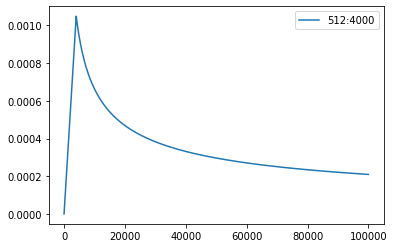

In [34]:
optimizer = NoamOpt(
    model_size=arch_args.encoder_embed_dim, 
    factor=config.lr_factor, 
    warmup=config.lr_warmup, 
    optimizer=torch.optim.AdamW(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9, weight_decay=0.0001))
plt.plot(np.arange(1, 100000), [optimizer.rate(i) for i in range(1, 100000)])
plt.legend([f"{optimizer.model_size}:{optimizer.warmup}"])
None

# Training Procedure  (backward model)

## Training(backward model)

In [11]:
from fairseq.data import iterators
from torch.cuda.amp import GradScaler, autocast

def train_one_epoch(epoch_itr, model, task, criterion, optimizer, accum_steps=1):
    itr = epoch_itr.next_epoch_itr(shuffle=True)
    itr = iterators.GroupedIterator(itr, accum_steps) # gradient accumulation: update every accum_steps samples
    
    stats = {"loss": []}
    scaler = GradScaler() # automatic mixed precision (amp) 
    
    model.train()
    progress = tqdm.tqdm(itr, desc=f"train epoch {epoch_itr.epoch}", leave=False)
    for samples in progress:
        model.zero_grad()
        accum_loss = 0
        sample_size = 0
        # gradient accumulation: update every accum_steps samples
        for i, sample in enumerate(samples):
            if i == 1:
                # emptying the CUDA cache after the first step can reduce the chance of OOM
                torch.cuda.empty_cache()

            sample = utils.move_to_cuda(sample, device=device)
            target = sample["target"]
            sample_size_i = sample["ntokens"]
            sample_size += sample_size_i
            
            # mixed precision training
            with autocast():
                net_output = model.forward(**sample["net_input"])
                lprobs = F.log_softmax(net_output[0], -1)            
                loss = criterion(lprobs.view(-1, lprobs.size(-1)), target.view(-1))
                
                # logging
                accum_loss += loss.item()
                # back-prop
                scaler.scale(loss).backward()                
        
        scaler.unscale_(optimizer)
        optimizer.multiply_grads(1 / (sample_size or 1.0)) # (sample_size or 1.0) handles the case of a zero gradient
        gnorm = nn.utils.clip_grad_norm_(model.parameters(), config.clip_norm) # grad norm clipping prevents gradient exploding
        
        scaler.step(optimizer)
        scaler.update()
        
        # logging
        loss_print = accum_loss/sample_size
        stats["loss"].append(loss_print)
        progress.set_postfix(loss=loss_print)
        if config.use_wandb:
            wandb.log({
                "train/loss": loss_print,
                "train/grad_norm": gnorm.item(),
                "train/lr": optimizer.rate(),
                "train/sample_size": sample_size,
            })
        
    loss_print = np.mean(stats["loss"])
    logger.info(f"training loss: {loss_print:.4f}")
    return stats

## Validation & Inference
To prevent overfitting, validation is required every epoch to validate the performance on unseen data.
- the procedure is essensially same as training, with the addition of inference step
- after validation we can save the model weights

Validation loss alone cannot describe the actual performance of the model
- Directly produce translation hypotheses based on current model, then calculate BLEU with the reference translation
- We can also manually examine the hypotheses' quality
- We use fairseq's sequence generator for beam search to generate translation hypotheses

In [12]:
# fairseq's beam search generator
# given model and input seqeunce, produce translation hypotheses by beam search
sequence_generator = task.build_generator([model], config)

def decode(toks, dictionary):
    # convert from Tensor to human readable sentence
    s = dictionary.string(
        toks.int().cpu(),
        config.post_process,
    )
    return s if s else "<unk>"

def inference_step(sample, model):
    gen_out = sequence_generator.generate([model], sample)
    srcs = []
    hyps = []
    refs = []
    for i in range(len(gen_out)):
        # for each sample, collect the input, hypothesis and reference, later be used to calculate BLEU
        srcs.append(decode(
            utils.strip_pad(sample["net_input"]["src_tokens"][i], task.source_dictionary.pad()), 
            task.source_dictionary,
        ))
        hyps.append(decode(
            gen_out[i][0]["tokens"], # 0 indicates using the top hypothesis in beam
            task.target_dictionary,
        ))
        refs.append(decode(
            utils.strip_pad(sample["target"][i], task.target_dictionary.pad()), 
            task.target_dictionary,
        ))
    return srcs, hyps, refs

In [13]:
import shutil
import sacrebleu

def validate(model, task, criterion, log_to_wandb=True):
    logger.info('begin validation')
    itr = load_data_iterator(task, "valid", 1, config.max_tokens, config.num_workers).next_epoch_itr(shuffle=False)
    
    stats = {"loss":[], "bleu": 0, "srcs":[], "hyps":[], "refs":[]}
    srcs = []
    hyps = []
    refs = []
    
    model.eval()
    progress = tqdm.tqdm(itr, desc=f"validation", leave=False)
    with torch.no_grad():
        for i, sample in enumerate(progress):
            # validation loss
            sample = utils.move_to_cuda(sample, device=device)
            net_output = model.forward(**sample["net_input"])

            lprobs = F.log_softmax(net_output[0], -1)
            target = sample["target"]
            sample_size = sample["ntokens"]
            loss = criterion(lprobs.view(-1, lprobs.size(-1)), target.view(-1)) / sample_size
            progress.set_postfix(valid_loss=loss.item())
            stats["loss"].append(loss)
            
            # do inference
            s, h, r = inference_step(sample, model)
            srcs.extend(s)
            hyps.extend(h)
            refs.extend(r)
            
    tok = 'zh' if task.cfg.target_lang == 'zh' else '13a'
    stats["loss"] = torch.stack(stats["loss"]).mean().item()
    stats["bleu"] = sacrebleu.corpus_bleu(hyps, [refs], tokenize=tok) # 計算BLEU score
    stats["srcs"] = srcs
    stats["hyps"] = hyps
    stats["refs"] = refs
    
    if config.use_wandb and log_to_wandb:
        wandb.log({
            "valid/loss": stats["loss"],
            "valid/bleu": stats["bleu"].score,
        }, commit=False)
    
    showid = np.random.randint(len(hyps))
    logger.info("example source: " + srcs[showid])
    logger.info("example hypothesis: " + hyps[showid])
    logger.info("example reference: " + refs[showid])
    
    # show bleu results
    logger.info(f"validation loss:\t{stats['loss']:.4f}")
    logger.info(stats["bleu"].format())
    return stats

# Save and Load Model Weights


In [14]:
def validate_and_save(model, task, criterion, optimizer, epoch, save=True):   
    stats = validate(model, task, criterion)
    bleu = stats['bleu']
    loss = stats['loss']
    if save:
        # save epoch checkpoints
        savedir = Path(config.savedir).absolute()
        savedir.mkdir(parents=True, exist_ok=True)
        
        check = {
            "model": model.state_dict(),
            "stats": {"bleu": bleu.score, "loss": loss},
            "optim": {"step": optimizer._step}
        }
        torch.save(check, savedir/f"checkpoint{epoch}.pt")
        shutil.copy(savedir/f"checkpoint{epoch}.pt", savedir/f"checkpoint_last.pt")
        logger.info(f"saved epoch checkpoint: {savedir}/checkpoint{epoch}.pt")
    
        # save epoch samples
        with open(savedir/f"samples{epoch}.{config.source_lang}-{config.target_lang}.txt", "w") as f:
            for s, h in zip(stats["srcs"], stats["hyps"]):
                f.write(f"{s}\t{h}\n")

        # get best valid bleu    
        if getattr(validate_and_save, "best_bleu", 0) < bleu.score:
            validate_and_save.best_bleu = bleu.score
            torch.save(check, savedir/f"checkpoint_best.pt")
            
        del_file = savedir / f"checkpoint{epoch - config.keep_last_epochs}.pt"
        if del_file.exists():
            del_file.unlink()
    
    return stats

def try_load_checkpoint(model, optimizer=None, name=None):
    name = name if name else "checkpoint_last.pt"
    checkpath = Path(config.savedir)/name
    if checkpath.exists():
        check = torch.load(checkpath)
        model.load_state_dict(check["model"])
        stats = check["stats"]
        step = "unknown"
        if optimizer != None:
            optimizer._step = step = check["optim"]["step"]
        logger.info(f"loaded checkpoint {checkpath}: step={step} loss={stats['loss']} bleu={stats['bleu']}")
    else:
        logger.info(f"no checkpoints found at {checkpath}!")

# Main
## Training loop

In [39]:
model = model.to(device=device)
criterion = criterion.to(device=device)

In [40]:
logger.info("task: {}".format(task.__class__.__name__))
logger.info("encoder: {}".format(model.encoder.__class__.__name__))
logger.info("decoder: {}".format(model.decoder.__class__.__name__))
logger.info("criterion: {}".format(criterion.__class__.__name__))
logger.info("optimizer: {}".format(optimizer.__class__.__name__))
logger.info(
    "num. model params: {:,} (num. trained: {:,})".format(
        sum(p.numel() for p in model.parameters()),
        sum(p.numel() for p in model.parameters() if p.requires_grad),
    )
)
logger.info(f"max tokens per batch = {config.max_tokens}, accumulate steps = {config.accum_steps}")

2022-03-20 16:49:38 | INFO | hw5.seq2seq | task: TranslationTask
2022-03-20 16:49:38 | INFO | hw5.seq2seq | encoder: TransformerEncoder
2022-03-20 16:49:38 | INFO | hw5.seq2seq | decoder: TransformerDecoder
2022-03-20 16:49:38 | INFO | hw5.seq2seq | criterion: LabelSmoothedCrossEntropyCriterion
2022-03-20 16:49:38 | INFO | hw5.seq2seq | optimizer: NoamOpt
2022-03-20 16:49:38 | INFO | hw5.seq2seq | num. model params: 52,332,544 (num. trained: 52,332,544)
2022-03-20 16:49:38 | INFO | hw5.seq2seq | max tokens per batch = 8192, accumulate steps = 2


In [41]:
epoch_itr = load_data_iterator(task, "train", config.start_epoch, config.max_tokens, config.num_workers)
try_load_checkpoint(model, optimizer, name=config.resume)
while epoch_itr.next_epoch_idx <= config.max_epoch:
    # train for one epoch
    train_one_epoch(epoch_itr, model, task, criterion, optimizer, config.accum_steps)
    stats = validate_and_save(model, task, criterion, optimizer, epoch=epoch_itr.epoch)
    logger.info("end of epoch {}".format(epoch_itr.epoch))    
    epoch_itr = load_data_iterator(task, "train", epoch_itr.next_epoch_idx, config.max_tokens, config.num_workers)

2022-03-20 16:49:38 | WARNING | fairseq.tasks.fairseq_task | 1 samples have invalid sizes and will be skipped, max_positions=(1024, 1024), first few sample ids=[326674]
2022-03-20 16:49:38 | INFO | hw5.seq2seq | loaded checkpoint checkpoints/zhToen/checkpoint_last.pt: step=3940 loss=3.0035789012908936 bleu=14.278902788913516


2022-03-20 16:53:23 | INFO | hw5.seq2seq | training loss: 3.0710
2022-03-20 16:53:23 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/26 [00:00<?, ?it/s, valid_loss=2.58]/home/tracy/miniconda3/envs/torch/lib/python3.9/site-packages/fairseq/search.py:140: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  beams_buf = indices_buf // vocab_size
/home/tracy/miniconda3/envs/torch/lib/python3.9/site-packages/fairseq/sequence_generator.py:657: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use

2022-03-20 16:53:45 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2022-03-20 16:53:45 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2022-03-20 16:53:45 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
2022-03-20 16:53:45 | INFO | hw5.seq2seq | example source: 它是個美麗的國家 , 位在西非 。
2022-03-20 16:53:45 | INFO | hw5.seq2seq | example hypothesis: it's a beautiful country in west africa .
2022-03-20 16:53:45 | INFO | hw5.seq2seq | example reference: it is a beautiful country located in west africa .
2022-03-20 16:53:45 | INFO | hw5.seq2seq | validation loss:	2.9056
2022-03-20 16:53:45 | INFO | hw5.seq2seq | BLEU = 15.85 53.6/24.1/12.5/6.7 (BP = 0.874 ratio = 0.882 hyp_len = 67933 ref_len = 77050)
2022-03-20 16:53:46 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/tracy/Projects/ML2022/hw5/checkpoints/zhToen/check

2022-03-20 16:57:29 | INFO | hw5.seq2seq | training loss: 2.9428
2022-03-20 16:57:29 | INFO | hw5.seq2seq | begin validation


2022-03-20 16:57:50 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2022-03-20 16:57:50 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2022-03-20 16:57:50 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
2022-03-20 16:57:50 | INFO | hw5.seq2seq | example source: 他懂得策略 。
2022-03-20 16:57:50 | INFO | hw5.seq2seq | example hypothesis: he understood strategy .
2022-03-20 16:57:50 | INFO | hw5.seq2seq | example reference: arthur samuel knew strategy .
2022-03-20 16:57:50 | INFO | hw5.seq2seq | validation loss:	2.8282
2022-03-20 16:57:50 | INFO | hw5.seq2seq | BLEU = 15.89 55.5/25.5/13.4/7.2 (BP = 0.826 ratio = 0.840 hyp_len = 64686 ref_len = 77050)
2022-03-20 16:57:51 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/tracy/Projects/ML2022/hw5/checkpoints/zhToen/checkpoint2.pt
2022-03-20 16:57:51 | INFO | hw5.seq2s

2022-03-20 17:01:35 | INFO | hw5.seq2seq | training loss: 2.8487
2022-03-20 17:01:35 | INFO | hw5.seq2seq | begin validation


2022-03-20 17:01:56 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2022-03-20 17:01:56 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2022-03-20 17:01:56 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
2022-03-20 17:01:56 | INFO | hw5.seq2seq | example source: 你可以成為傑出的一代 。 」
2022-03-20 17:01:56 | INFO | hw5.seq2seq | example hypothesis: you can be a brilliant generation . "
2022-03-20 17:01:56 | INFO | hw5.seq2seq | example reference: you can be that great generation . "
2022-03-20 17:01:56 | INFO | hw5.seq2seq | validation loss:	2.7817
2022-03-20 17:01:56 | INFO | hw5.seq2seq | BLEU = 17.05 56.0/26.4/14.2/7.9 (BP = 0.845 ratio = 0.855 hyp_len = 65913 ref_len = 77050)
2022-03-20 17:01:57 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/tracy/Projects/ML2022/hw5/checkpoints/zhToen/checkpoint3.pt
2022-03-20 

2022-03-20 17:05:42 | INFO | hw5.seq2seq | training loss: 2.7714
2022-03-20 17:05:42 | INFO | hw5.seq2seq | begin validation


2022-03-20 17:06:03 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2022-03-20 17:06:03 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2022-03-20 17:06:03 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
2022-03-20 17:06:03 | INFO | hw5.seq2seq | example source: 它驅使人們離開大腦聰明的那部份那個潛意識的黑暗深井本能和經驗所在的地方以及所有其他創意的元素還有良好判斷力所在之處它迫使我們去到單薄又呆板有意識的邏輯 。
2022-03-20 17:06:03 | INFO | hw5.seq2seq | example hypothesis: it drives people out of the smart parts of the unconsciousness of the subconsciousness of the experience , where the elements of all other creativity and good judgments , and it forces us to go to a very thin and silly logic .
2022-03-20 17:06:03 | INFO | hw5.seq2seq | example reference: it drives people from the smart part of the brain that dark , deep well of the subconscious , where instincts and experience , and

2022-03-20 17:09:49 | INFO | hw5.seq2seq | training loss: 2.7513
2022-03-20 17:09:49 | INFO | hw5.seq2seq | begin validation


2022-03-20 17:10:11 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2022-03-20 17:10:11 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2022-03-20 17:10:11 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
2022-03-20 17:10:11 | INFO | hw5.seq2seq | example source: 「 事情並無好壞/是我們的思維使之如此 」
2022-03-20 17:10:11 | INFO | hw5.seq2seq | example hypothesis: " things aren't bad or bad or are our minds . "
2022-03-20 17:10:11 | INFO | hw5.seq2seq | example reference: that seems like a onequestion iq test .
2022-03-20 17:10:11 | INFO | hw5.seq2seq | validation loss:	2.6988
2022-03-20 17:10:11 | INFO | hw5.seq2seq | BLEU = 18.49 55.5/26.6/14.5/8.1 (BP = 0.905 ratio = 0.909 hyp_len = 70056 ref_len = 77050)
2022-03-20 17:10:11 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/tracy/Projects/ML2022/hw5/checkpoints/zhToen/checkp

2022-03-20 17:13:55 | INFO | hw5.seq2seq | training loss: 2.7050
2022-03-20 17:13:55 | INFO | hw5.seq2seq | begin validation


2022-03-20 17:14:17 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2022-03-20 17:14:17 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2022-03-20 17:14:17 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
2022-03-20 17:14:17 | INFO | hw5.seq2seq | example source: 謝謝 。
2022-03-20 17:14:17 | INFO | hw5.seq2seq | example hypothesis: thank you very much .
2022-03-20 17:14:17 | INFO | hw5.seq2seq | example reference: thank you .
2022-03-20 17:14:17 | INFO | hw5.seq2seq | validation loss:	2.6726
2022-03-20 17:14:17 | INFO | hw5.seq2seq | BLEU = 18.86 56.0/27.0/15.0/8.6 (BP = 0.899 ratio = 0.904 hyp_len = 69617 ref_len = 77050)
2022-03-20 17:14:17 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/tracy/Projects/ML2022/hw5/checkpoints/zhToen/checkpoint6.pt
2022-03-20 17:14:18 | INFO | hw5.seq2seq | end of epoch 6


2022-03-20 17:18:02 | INFO | hw5.seq2seq | training loss: 2.6681
2022-03-20 17:18:02 | INFO | hw5.seq2seq | begin validation


2022-03-20 17:18:23 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2022-03-20 17:18:23 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2022-03-20 17:18:23 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
2022-03-20 17:18:23 | INFO | hw5.seq2seq | example source: 不 。
2022-03-20 17:18:23 | INFO | hw5.seq2seq | example hypothesis: no .
2022-03-20 17:18:23 | INFO | hw5.seq2seq | example reference: no .
2022-03-20 17:18:23 | INFO | hw5.seq2seq | validation loss:	2.6579
2022-03-20 17:18:23 | INFO | hw5.seq2seq | BLEU = 19.15 57.3/28.1/15.7/9.0 (BP = 0.877 ratio = 0.884 hyp_len = 68085 ref_len = 77050)
2022-03-20 17:18:24 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/tracy/Projects/ML2022/hw5/checkpoints/zhToen/checkpoint7.pt
2022-03-20 17:18:25 | INFO | hw5.seq2seq | end of epoch 7


2022-03-20 17:22:07 | INFO | hw5.seq2seq | training loss: 2.6363
2022-03-20 17:22:07 | INFO | hw5.seq2seq | begin validation


2022-03-20 17:22:29 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2022-03-20 17:22:29 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2022-03-20 17:22:29 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
2022-03-20 17:22:29 | INFO | hw5.seq2seq | example source: 自行車是只在美國南部一些城市正在進行的革命
2022-03-20 17:22:29 | INFO | hw5.seq2seq | example hypothesis: bicycles are revolutions in the southern part of the country .
2022-03-20 17:22:29 | INFO | hw5.seq2seq | example reference: bicycles and bicycling are the current revolution underway in only some american cities .
2022-03-20 17:22:29 | INFO | hw5.seq2seq | validation loss:	2.6362
2022-03-20 17:22:29 | INFO | hw5.seq2seq | BLEU = 19.67 57.4/28.4/15.9/9.2 (BP = 0.890 ratio = 0.896 hyp_len = 69031 ref_len = 77050)
2022-03-20 17:22:30 | INFO | hw5.seq2seq | saved epoch chec

2022-03-20 17:26:14 | INFO | hw5.seq2seq | training loss: 2.6082
2022-03-20 17:26:14 | INFO | hw5.seq2seq | begin validation


2022-03-20 17:26:35 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2022-03-20 17:26:35 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2022-03-20 17:26:35 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
2022-03-20 17:26:35 | INFO | hw5.seq2seq | example source: jc:我覺得很有意思 。
2022-03-20 17:26:35 | INFO | hw5.seq2seq | example hypothesis: jc: i think it's interesting .
2022-03-20 17:26:35 | INFO | hw5.seq2seq | example reference: jc: it makes perfect sense to me .
2022-03-20 17:26:35 | INFO | hw5.seq2seq | validation loss:	2.6288
2022-03-20 17:26:35 | INFO | hw5.seq2seq | BLEU = 19.29 57.4/28.2/15.7/9.0 (BP = 0.881 ratio = 0.888 hyp_len = 68398 ref_len = 77050)
2022-03-20 17:26:36 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/tracy/Projects/ML2022/hw5/checkpoints/zhToen/checkpoint9.pt
2022-03-20 17:26:36 | 

2022-03-20 17:30:21 | INFO | hw5.seq2seq | training loss: 2.5839
2022-03-20 17:30:21 | INFO | hw5.seq2seq | begin validation


2022-03-20 17:30:43 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2022-03-20 17:30:43 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2022-03-20 17:30:43 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
2022-03-20 17:30:43 | INFO | hw5.seq2seq | example source: 這就是問題所在彼得‧德森指出了這點他用的例子是某種鴨嘴恐龍當時被稱為亞冠龍
2022-03-20 17:30:43 | INFO | hw5.seq2seq | example hypothesis: and that's the problem , and peter dson pointed out that he uses an example of a duck dinosaur called champion .
2022-03-20 17:30:43 | INFO | hw5.seq2seq | example reference: so this was a problem , and peter dodson pointed this out using some duckbilled dinosaurs then called hypacrosaurus .
2022-03-20 17:30:43 | INFO | hw5.seq2seq | validation loss:	2.6222
2022-03-20 17:30:43 | INFO | hw5.seq2seq | BLEU = 19.26 57.9/28.5/16.0/9.2 (BP = 0.867 ratio = 0.87

2022-03-20 17:34:27 | INFO | hw5.seq2seq | training loss: 2.5629
2022-03-20 17:34:27 | INFO | hw5.seq2seq | begin validation


2022-03-20 17:34:49 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2022-03-20 17:34:49 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2022-03-20 17:34:49 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
2022-03-20 17:34:49 | INFO | hw5.seq2seq | example source: 她說: 「 放下你的身段 , 錢是『綠色』的 。 」
2022-03-20 17:34:49 | INFO | hw5.seq2seq | example hypothesis: she said , " let's put down your status , money is green . "
2022-03-20 17:34:49 | INFO | hw5.seq2seq | example reference: she said , " get off your throne . money is green . "
2022-03-20 17:34:49 | INFO | hw5.seq2seq | validation loss:	2.6043
2022-03-20 17:34:49 | INFO | hw5.seq2seq | BLEU = 20.43 56.3/27.9/15.8/9.2 (BP = 0.935 ratio = 0.937 hyp_len = 72188 ref_len = 77050)
2022-03-20 17:34:50 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/tracy/Projects/ML20

2022-03-20 17:38:34 | INFO | hw5.seq2seq | training loss: 2.5429
2022-03-20 17:38:34 | INFO | hw5.seq2seq | begin validation


2022-03-20 17:38:56 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2022-03-20 17:38:56 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2022-03-20 17:38:56 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
2022-03-20 17:38:56 | INFO | hw5.seq2seq | example source: 成為領導者是我的抱負 , 我想問 , 在沒有影響力時 , 你要如何領導 ?
2022-03-20 17:38:56 | INFO | hw5.seq2seq | example hypothesis: being a leader is my aspiration , and i want to ask , how do you lead without influence ?
2022-03-20 17:38:56 | INFO | hw5.seq2seq | example reference: i'm an aspiring leader , and i have a question about how you lead when you have no influence .
2022-03-20 17:38:56 | INFO | hw5.seq2seq | validation loss:	2.5945
2022-03-20 17:38:56 | INFO | hw5.seq2seq | BLEU = 20.77 56.1/28.0/15.9/9.3 (BP = 0.947 ratio = 0.948 hyp_len = 73044 ref_len = 77050)
2022-03-20 

2022-03-20 17:42:42 | INFO | hw5.seq2seq | training loss: 2.5248
2022-03-20 17:42:42 | INFO | hw5.seq2seq | begin validation


2022-03-20 17:43:04 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2022-03-20 17:43:04 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2022-03-20 17:43:04 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
2022-03-20 17:43:04 | INFO | hw5.seq2seq | example source: 這樣 , 英國國教的牧師就可以教訓無神論者 , 說他們的言論有多麼冒犯人 ;
2022-03-20 17:43:04 | INFO | hw5.seq2seq | example hypothesis: in doing so , the priests of the british state can teach the atheist how offensive they are .
2022-03-20 17:43:04 | INFO | hw5.seq2seq | example reference: so anglican ministers could lecture atheists on the offensiveness of their discourse .
2022-03-20 17:43:04 | INFO | hw5.seq2seq | validation loss:	2.5931
2022-03-20 17:43:04 | INFO | hw5.seq2seq | BLEU = 20.21 58.4/29.4/16.7/9.7 (BP = 0.880 ratio = 0.887 hyp_len = 68314 ref_len = 77050)
2022-03-20 17:

2022-03-20 17:46:49 | INFO | hw5.seq2seq | training loss: 2.5068
2022-03-20 17:46:49 | INFO | hw5.seq2seq | begin validation


2022-03-20 17:47:11 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2022-03-20 17:47:11 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2022-03-20 17:47:11 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
2022-03-20 17:47:11 | INFO | hw5.seq2seq | example source: 所以 , 我們說 , 好 , 咱們來研究看看這是如何發生的 , 先看科學 。
2022-03-20 17:47:11 | INFO | hw5.seq2seq | example hypothesis: so we said , ok , let's look at how this is happening , first looking at science .
2022-03-20 17:47:11 | INFO | hw5.seq2seq | example reference: so we said , ok , let's figure out how does this really happen , first in science .
2022-03-20 17:47:11 | INFO | hw5.seq2seq | validation loss:	2.5821
2022-03-20 17:47:11 | INFO | hw5.seq2seq | BLEU = 20.65 57.5/28.9/16.4/9.6 (BP = 0.913 ratio = 0.917 hyp_len = 70626 ref_len = 77050)
2022-03-20 17:47:11 | INFO |

2022-03-20 17:50:55 | INFO | hw5.seq2seq | training loss: 2.4922
2022-03-20 17:50:55 | INFO | hw5.seq2seq | begin validation


2022-03-20 17:51:17 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2022-03-20 17:51:17 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2022-03-20 17:51:17 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
2022-03-20 17:51:17 | INFO | hw5.seq2seq | example source: 然而此時此刻我們滅絕這些病症的能力也已經達到了超乎想像的高峰
2022-03-20 17:51:17 | INFO | hw5.seq2seq | example hypothesis: but at this point , our ability to extinct these symptoms has reached peaks that are beyond our imagination .
2022-03-20 17:51:17 | INFO | hw5.seq2seq | example reference: and yet we also live at the moment when our ability to eliminate those conditions has reached a height we never imagined before .
2022-03-20 17:51:17 | INFO | hw5.seq2seq | validation loss:	2.5756
2022-03-20 17:51:17 | INFO | hw5.seq2seq | BLEU = 21.03 55.9/28.0/15.9/9.2 (BP = 0.961 ratio = 0.

2022-03-20 17:55:04 | INFO | hw5.seq2seq | training loss: 2.4801
2022-03-20 17:55:04 | INFO | hw5.seq2seq | begin validation


2022-03-20 17:55:26 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2022-03-20 17:55:26 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2022-03-20 17:55:26 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
2022-03-20 17:55:26 | INFO | hw5.seq2seq | example source: 是因為勤奮的工作 。 是因為我們發現了有關恐怖活動的情報並且以不同的方式禁止 , 通過執法 , 通過和其他國家的合作 , 而且有時候通過軍事活動 。
2022-03-20 17:55:26 | INFO | hw5.seq2seq | example hypothesis: it's because of diligent work , because we discovered intelligence about terrorism and banned it in a different way , through law enforcement , through collaboration with other countries and sometimes through military activities .
2022-03-20 17:55:26 | INFO | hw5.seq2seq | example reference: that's hard work . that's us finding intelligence on terrorist activities and interdicting them through one way or another , thro

2022-03-20 17:59:12 | INFO | hw5.seq2seq | training loss: 2.4653
2022-03-20 17:59:12 | INFO | hw5.seq2seq | begin validation


2022-03-20 17:59:34 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2022-03-20 17:59:34 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2022-03-20 17:59:34 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
2022-03-20 17:59:34 | INFO | hw5.seq2seq | example source: 這是過去40年來女性不斷倡導的結果
2022-03-20 17:59:34 | INFO | hw5.seq2seq | example hypothesis: this is what women have been advocating for over the last 40 years .
2022-03-20 17:59:34 | INFO | hw5.seq2seq | example reference: and that is the 40 years that women have advocated .
2022-03-20 17:59:34 | INFO | hw5.seq2seq | validation loss:	2.5658
2022-03-20 17:59:34 | INFO | hw5.seq2seq | BLEU = 20.69 57.8/29.2/16.7/9.9 (BP = 0.902 ratio = 0.906 hyp_len = 69834 ref_len = 77050)
2022-03-20 17:59:35 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/tracy/Projects/ML2022

2022-03-20 18:03:18 | INFO | hw5.seq2seq | training loss: 2.4534
2022-03-20 18:03:18 | INFO | hw5.seq2seq | begin validation


2022-03-20 18:03:40 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2022-03-20 18:03:40 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2022-03-20 18:03:40 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
2022-03-20 18:03:40 | INFO | hw5.seq2seq | example source: 所有人都安全了 。
2022-03-20 18:03:40 | INFO | hw5.seq2seq | example hypothesis: everyone's safe .
2022-03-20 18:03:40 | INFO | hw5.seq2seq | example reference: and no one got killed .
2022-03-20 18:03:40 | INFO | hw5.seq2seq | validation loss:	2.5615
2022-03-20 18:03:40 | INFO | hw5.seq2seq | BLEU = 21.16 58.3/29.7/17.1/10.2 (BP = 0.902 ratio = 0.907 hyp_len = 69849 ref_len = 77050)
2022-03-20 18:03:41 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/tracy/Projects/ML2022/hw5/checkpoints/zhToen/checkpoint18.pt
2022-03-20 18:03:41 | INFO | hw5.seq2seq | end 

2022-03-20 18:07:27 | INFO | hw5.seq2seq | training loss: 2.4411
2022-03-20 18:07:27 | INFO | hw5.seq2seq | begin validation


2022-03-20 18:07:49 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2022-03-20 18:07:49 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2022-03-20 18:07:49 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
2022-03-20 18:07:49 | INFO | hw5.seq2seq | example source: 其他人則是靠著很不適合的獨木舟 , 孤注一擲試圖前往西班牙 。
2022-03-20 18:07:49 | INFO | hw5.seq2seq | example hypothesis: others use very bad canoes to try to travel to spain .
2022-03-20 18:07:49 | INFO | hw5.seq2seq | example reference: others end up on inadequate wooden canoes in desperate attempts to reach spain .
2022-03-20 18:07:49 | INFO | hw5.seq2seq | validation loss:	2.5591
2022-03-20 18:07:49 | INFO | hw5.seq2seq | BLEU = 21.12 58.1/29.5/17.0/10.1 (BP = 0.906 ratio = 0.910 hyp_len = 70108 ref_len = 77050)
2022-03-20 18:07:50 | INFO | hw5.seq2seq | saved epoch checkpoint

2022-03-20 18:11:35 | INFO | hw5.seq2seq | training loss: 2.4303
2022-03-20 18:11:35 | INFO | hw5.seq2seq | begin validation


2022-03-20 18:11:57 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2022-03-20 18:11:57 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2022-03-20 18:11:57 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
2022-03-20 18:11:57 | INFO | hw5.seq2seq | example source: 對了 , 如果你還沒有注意到 , 我是黑人 , 謝謝 。 如果你像我一樣 , 生長在種族隔離的城市 , 例如芝加哥 , 你自然而然就相信膚色和種族永遠是分不開的 。
2022-03-20 18:11:57 | INFO | hw5.seq2seq | example hypothesis: by the way , if you haven't noticed that i am black , thank you , and if you grow in a segregated city , like in chicago , you naturally believe that color and race are never separated .
2022-03-20 18:11:57 | INFO | hw5.seq2seq | example reference: now , if you haven't noticed , i am black , thank you and when you grow up in a segregated city as i have , like chicago , you're conditioned to believe that color a

2022-03-20 18:15:41 | INFO | hw5.seq2seq | training loss: 2.4199
2022-03-20 18:15:41 | INFO | hw5.seq2seq | begin validation


2022-03-20 18:16:03 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2022-03-20 18:16:03 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2022-03-20 18:16:03 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
2022-03-20 18:16:03 | INFO | hw5.seq2seq | example source: 如果你是使用蘋果的keynote , 就有更好的版本能用
2022-03-20 18:16:03 | INFO | hw5.seq2seq | example hypothesis: if you're using the kynote of apple , there's a better version of it .
2022-03-20 18:16:03 | INFO | hw5.seq2seq | example reference: if you use apple's keynote , it's got an even better version .
2022-03-20 18:16:03 | INFO | hw5.seq2seq | validation loss:	2.5547
2022-03-20 18:16:03 | INFO | hw5.seq2seq | BLEU = 21.29 57.6/29.2/16.8/10.0 (BP = 0.923 ratio = 0.926 hyp_len = 71338 ref_len = 77050)
2022-03-20 18:16:04 | INFO | hw5.seq2seq | saved epoch checkpoint: /ho

2022-03-20 18:19:50 | INFO | hw5.seq2seq | training loss: 2.4101
2022-03-20 18:19:50 | INFO | hw5.seq2seq | begin validation


2022-03-20 18:20:12 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2022-03-20 18:20:12 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2022-03-20 18:20:12 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
2022-03-20 18:20:12 | INFO | hw5.seq2seq | example source: 這是1970年中國的收入分配
2022-03-20 18:20:12 | INFO | hw5.seq2seq | example hypothesis: this is china's income distribution in 1970 .
2022-03-20 18:20:12 | INFO | hw5.seq2seq | example reference: this is the income distribution of china , 1970 .
2022-03-20 18:20:12 | INFO | hw5.seq2seq | validation loss:	2.5543
2022-03-20 18:20:12 | INFO | hw5.seq2seq | BLEU = 21.09 58.4/29.6/17.0/10.1 (BP = 0.902 ratio = 0.907 hyp_len = 69856 ref_len = 77050)
2022-03-20 18:20:13 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/tracy/Projects/ML2022/hw5/checkpoints/zhToen/chec

2022-03-20 18:23:58 | INFO | hw5.seq2seq | training loss: 2.4010
2022-03-20 18:23:58 | INFO | hw5.seq2seq | begin validation


2022-03-20 18:24:21 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2022-03-20 18:24:21 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2022-03-20 18:24:21 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
2022-03-20 18:24:21 | INFO | hw5.seq2seq | example source: 他是律師兼作家 , 笑的時候眼睛閃閃發光 , 我親他的時候 , 他緊緊閉上雙眼 , 在那晚的某一刻 , 我們的第零次約會
2022-03-20 18:24:21 | INFO | hw5.seq2seq | example hypothesis: he's a lawyer and a writer , and he's laughing , and he's flashing , and when i first saw him , he closes his eyes , and at some point , our zero date that night .
2022-03-20 18:24:21 | INFO | hw5.seq2seq | example reference: he was a lawyer and a writer , and his eyes twinkled when he laughed and they squeezed tight when i kissed him and at some point in the evening , our zero date became a first date .
2022-03-20 18:24:21 | INFO |

2022-03-20 18:28:05 | INFO | hw5.seq2seq | training loss: 2.3919
2022-03-20 18:28:05 | INFO | hw5.seq2seq | begin validation


2022-03-20 18:28:27 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2022-03-20 18:28:27 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2022-03-20 18:28:27 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
2022-03-20 18:28:27 | INFO | hw5.seq2seq | example source: 用特斯拉 , 因你要有永續能源 , 所以造出這麽勁爆的車子來實現你的目標 。
2022-03-20 18:28:27 | INFO | hw5.seq2seq | example hypothesis: using tesla , because you've got to have sustainable energy , you've got to create this explosive car to realize your goals .
2022-03-20 18:28:27 | INFO | hw5.seq2seq | example reference: with tesla , you want to have sustainable energy , so you made these super sexy , exciting cars to do it .
2022-03-20 18:28:27 | INFO | hw5.seq2seq | validation loss:	2.5506
2022-03-20 18:28:27 | INFO | hw5.seq2seq | BLEU = 21.41 57.9/29.4/17.0/10.1 (BP = 0.922 ratio = 

2022-03-20 18:32:16 | INFO | hw5.seq2seq | training loss: 2.3847
2022-03-20 18:32:16 | INFO | hw5.seq2seq | begin validation


2022-03-20 18:32:38 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2022-03-20 18:32:38 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2022-03-20 18:32:38 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
2022-03-20 18:32:38 | INFO | hw5.seq2seq | example source: 你要做的 , 就是把你的問題和以前別人所遇到的問題做比對 , 再利用他們已經想出的辦法來解決 。
2022-03-20 18:32:38 | INFO | hw5.seq2seq | example hypothesis: all you have to do is compare your problems to the problems that other people have faced before , and then use the solutions that they've figured out .
2022-03-20 18:32:38 | INFO | hw5.seq2seq | example reference: because what you can do is take your problem , and turn it into a problem that someone else has solved , and use their solutions .
2022-03-20 18:32:38 | INFO | hw5.seq2seq | validation loss:	2.5423
2022-03-20 18:32:38 | INFO | hw5.seq

2022-03-20 18:36:24 | INFO | hw5.seq2seq | training loss: 2.3775
2022-03-20 18:36:24 | INFO | hw5.seq2seq | begin validation


2022-03-20 18:36:45 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2022-03-20 18:36:45 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2022-03-20 18:36:45 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
2022-03-20 18:36:45 | INFO | hw5.seq2seq | example source: 在同樣的狀況下他們該怎麼做 ?
2022-03-20 18:36:45 | INFO | hw5.seq2seq | example hypothesis: what do they do in the same situation ?
2022-03-20 18:36:45 | INFO | hw5.seq2seq | example reference: what would they do under the same conditions ?
2022-03-20 18:36:45 | INFO | hw5.seq2seq | validation loss:	2.5467
2022-03-20 18:36:45 | INFO | hw5.seq2seq | BLEU = 21.55 58.3/29.9/17.3/10.3 (BP = 0.913 ratio = 0.917 hyp_len = 70650 ref_len = 77050)
2022-03-20 18:36:46 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/tracy/Projects/ML2022/hw5/checkpoints/zhToen/checkpoint26

2022-03-20 18:40:30 | INFO | hw5.seq2seq | training loss: 2.3686
2022-03-20 18:40:30 | INFO | hw5.seq2seq | begin validation


2022-03-20 18:40:52 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2022-03-20 18:40:52 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2022-03-20 18:40:52 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
2022-03-20 18:40:52 | INFO | hw5.seq2seq | example source: 這帶給我想到第三個假設而這也許是問題最大的假設: " 永遠不要對選擇說不 " 。
2022-03-20 18:40:52 | INFO | hw5.seq2seq | example hypothesis: and that brings me to my third assumption , and maybe that's the biggest assumption: " never say no to the choice . "
2022-03-20 18:40:52 | INFO | hw5.seq2seq | example reference: this brings me to the third , and perhaps most problematic , assumption: " you must never say no to choice . "
2022-03-20 18:40:52 | INFO | hw5.seq2seq | validation loss:	2.5405
2022-03-20 18:40:52 | INFO | hw5.seq2seq | BLEU = 21.37 58.3/29.8/17.2/10.2 (BP = 0.911 ratio = 0.

2022-03-20 18:44:37 | INFO | hw5.seq2seq | training loss: 2.3612
2022-03-20 18:44:37 | INFO | hw5.seq2seq | begin validation


2022-03-20 18:44:59 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2022-03-20 18:44:59 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2022-03-20 18:44:59 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
2022-03-20 18:44:59 | INFO | hw5.seq2seq | example source: 沒有錢乘車 , 他們通常都會坐在卡車頂上 , 在這裡則是坐在橫越南蘇丹的火車頂上 。
2022-03-20 18:44:59 | INFO | hw5.seq2seq | example hypothesis: without money , they usually sit on the roof of a truck , and here they are on the roof of a train across south sudan .
2022-03-20 18:44:59 | INFO | hw5.seq2seq | example reference: with no money for rides , they often made the mzungu ride on the roof of the trucks , or in this case , on the top of the train going across south sudan .
2022-03-20 18:44:59 | INFO | hw5.seq2seq | validation loss:	2.5388
2022-03-20 18:44:59 | INFO | hw5.seq2seq | BLEU = 

2022-03-20 18:48:48 | INFO | hw5.seq2seq | training loss: 2.3543
2022-03-20 18:48:48 | INFO | hw5.seq2seq | begin validation


2022-03-20 18:49:09 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2022-03-20 18:49:09 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2022-03-20 18:49:09 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
2022-03-20 18:49:09 | INFO | hw5.seq2seq | example source: 我可以把鏡頭向右旋轉一點 , 你就會失焦 , 而背景的人會凸顯出來 。
2022-03-20 18:49:09 | INFO | hw5.seq2seq | example hypothesis: i can rotate the camera a little bit to the right , and you lose the focus , and the background reveals it .
2022-03-20 18:49:09 | INFO | hw5.seq2seq | example reference: i could move the lens a little to the right , and you would go back and the folks in the background would come out .
2022-03-20 18:49:09 | INFO | hw5.seq2seq | validation loss:	2.5400
2022-03-20 18:49:09 | INFO | hw5.seq2seq | BLEU = 21.28 58.4/29.9/17.3/10.3 (BP = 0.902 ratio = 0.906 hyp_

2022-03-20 18:52:54 | INFO | hw5.seq2seq | training loss: 2.3467
2022-03-20 18:52:54 | INFO | hw5.seq2seq | begin validation


2022-03-20 18:53:17 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2022-03-20 18:53:17 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2022-03-20 18:53:17 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
2022-03-20 18:53:17 | INFO | hw5.seq2seq | example source: 身為白人女性 , 我們得要做更多 , 因為種族主義、性別主義 , 和恐同性戀症 , 是影響我們所有人的議題 。
2022-03-20 18:53:17 | INFO | hw5.seq2seq | example hypothesis: as white women , we need to do more because racism , gender and terrorism are issues that affect all of us .
2022-03-20 18:53:17 | INFO | hw5.seq2seq | example reference: and as white women , we have to do more , because racism and sexism and homophobia , these are issues that affect all of us .
2022-03-20 18:53:17 | INFO | hw5.seq2seq | validation loss:	2.5360
2022-03-20 18:53:17 | INFO | hw5.seq2seq | BLEU = 21.68 57.7/29.4/17.0/10.1 (

# Submission

In [47]:
# averaging a few checkpoints can have a similar effect to ensemble

checkdir=config.savedir
!python ./fairseq/scripts/average_checkpoints.py \
--inputs {checkdir} \
--num-epoch-checkpoints 5 \
--output {checkdir}/avg_last_5_checkpoint.pt

Namespace(inputs=['./checkpoints/zhToen'], output='./checkpoints/zhToen/avg_last_5_checkpoint.pt', num_epoch_checkpoints=5, num_update_checkpoints=None, checkpoint_upper_bound=None)
averaging checkpoints:  ['./checkpoints/zhToen/checkpoint30.pt', './checkpoints/zhToen/checkpoint29.pt', './checkpoints/zhToen/checkpoint28.pt', './checkpoints/zhToen/checkpoint27.pt', './checkpoints/zhToen/checkpoint26.pt']
Finished writing averaged checkpoint to ./checkpoints/zhToen/avg_last_5_checkpoint.pt


## Confirm model weights used to generate submission

In [48]:
# checkpoint_last.pt : latest epoch
# checkpoint_best.pt : highest validation bleu
# avg_last_5_checkpoint.pt:　the average of last 5 epochs

try_load_checkpoint(model, name="avg_last_5_checkpoint.pt")
validate(model, task, criterion, log_to_wandb=False)
None

2022-03-20 20:23:58 | INFO | hw5.seq2seq | loaded checkpoint checkpoints/zhToen/avg_last_5_checkpoint.pt: step=unknown loss=2.536004066467285 bleu=21.679366760451536
2022-03-20 20:23:58 | INFO | hw5.seq2seq | begin validation


2022-03-20 20:24:19 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2022-03-20 20:24:19 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2022-03-20 20:24:19 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
2022-03-20 20:24:19 | INFO | hw5.seq2seq | example source: 我覺得沒人在乎我 , 鋃鐺入獄讓我滿腹怨恨 。
2022-03-20 20:24:19 | INFO | hw5.seq2seq | example hypothesis: i think nobody cares about me , bonding in jail makes me complain .
2022-03-20 20:24:19 | INFO | hw5.seq2seq | example reference: i felt like nobody cared , and i reacted with hostility to my confinement .
2022-03-20 20:24:19 | INFO | hw5.seq2seq | validation loss:	2.5241
2022-03-20 20:24:19 | INFO | hw5.seq2seq | BLEU = 21.76 58.5/30.1/17.4/10.4 (BP = 0.916 ratio = 0.920 hyp_len = 70860 ref_len = 77050)


## Generate Prediction

In [15]:
def generate_prediction(model, task, split="test", outfile="./prediction.txt"):    
    task.load_dataset(split=split, epoch=1)
    itr = load_data_iterator(task, split, 1, config.max_tokens, config.num_workers).next_epoch_itr(shuffle=False)
    
    idxs = []
    hyps = []

    model.eval()
    progress = tqdm.tqdm(itr, desc=f"prediction")
    with torch.no_grad():
        for i, sample in enumerate(progress):
            # validation loss
            sample = utils.move_to_cuda(sample, device=device)

            # do inference
            s, h, r = inference_step(sample, model)
            
            hyps.extend(h)
            idxs.extend(list(sample['id']))
            
    # sort based on the order before preprocess
    hyps = [x for _,x in sorted(zip(idxs,hyps))]
    
    with open(outfile, "w") as f:
        for h in hyps:
            f.write(h+"\n")

In [45]:
# generate_prediction(model, task)

In [46]:
raise

RuntimeError: No active exception to reraise

# Back-translation

## Train a backward translation model

1. Switch the source_lang and target_lang in **config** 
2. Change the savedir in **config** (eg. "./checkpoints/transformer-back")
3. Train model

## Generate synthetic data with backward model 

### Download monolingual data

In [50]:
data_dir = './DATA/rawdata'
mono_dataset_name = 'mono'
mono_prefix = Path(data_dir).absolute() / mono_dataset_name
# mono_prefix.mkdir(parents=True, exist_ok=True)

# urls = (
#     "https://github.com/yuhsinchan/ML2022-HW5Dataset/releases/download/v1.0.2/ted_zh_corpus.deduped.gz"
# )
# file_names = (
#     'ted_zh_corpus.deduped.gz',
# )

# for u, f in zip(urls, file_names):
#     path = mono_prefix/f
#     if not path.exists():
#         !wget {u} -O {path}
#     else:
#         print(f'{f} is exist, skip downloading')
#     if path.suffix == ".tgz":
#         !tar -xvf {path} -C {prefix}
#     elif path.suffix == ".zip":
#         !unzip -o {path} -d {prefix}
#     elif path.suffix == ".gz":
#         !gzip -fkd {path}

### TODO: clean corpus

1. remove sentences that are too long or too short
2. unify punctuation

hint: you can use clean_s() defined above to do this

In [ ]:
mono_path = "./DATA/rawdata/mono/ted_zh_corpus.deduped"
mono_clean = "./DATA/rawdata/mono/ted_zh_corpus.deduped.clean"


if Path(f'{mono_clean}').exists():
    print(f'{mono_clean} exists. skipping clean.')
else:
    max_len, min_len = 1000, 1
    with open(mono_path, 'r') as mono_o:
        with open(mono_clean, 'w') as mono_c:
            for s in mono_o:
                s = s.strip()
                s = clean_s(s, 'zh')
                s_len = len_s(s,'zh')
                if s_len < min_len or s_len > max_len:
                    continue
                print(s, file=mono_c)

./DATA/rawdata/mono/ted_zh_corpus.deduped.clean exists. skipping clean.


### TODO: Subword Units

Use the spm model of the backward model to tokenize the data into subword units

hint: spm model is located at DATA/raw-data/\[dataset\]/spm\[vocab_num\].model

In [ ]:
import sentencepiece as spm
vocab_size = 8000
if (mono_prefix/f'spm{vocab_size}.model').exists():
    print(f'{mono_prefix}/spm{vocab_size}.model exists. skipping spm_train.')
else:
    spm.SentencePieceTrainer.train(
        input=mono_clean,
        model_prefix=mono_prefix/f'spm{vocab_size}',
        vocab_size=vocab_size,
        character_coverage=1,
        model_type='unigram', # 'bpe' 也可
        input_sentence_size=1e6,
        shuffle_input_sentence=True,
        normalization_rule_name='nmt_nfkc_cf',
    )
spm_model_mono = spm.SentencePieceProcessor(model_file=str(mono_prefix/f'spm{vocab_size}.model'))


out_path = mono_prefix/f'mono_train.zh'
if out_path.exists():
    print(f"{out_path} exists. skipping spm_encode.")
else:
    with open(f"{out_path}", 'w') as out_f:
        with open(mono_clean, 'r') as in_f:
            for line in in_f:
                line = line.strip()
                tok = spm_model_mono.encode(line, out_type=str)
                print(' '.join(tok), file=out_f)

/home/tracy/Projects/ML2022/hw5/DATA/rawdata/mono/spm8000.model exists. skipping spm_train.
/home/tracy/Projects/ML2022/hw5/DATA/rawdata/mono/mono_train.zh exists. skipping spm_encode.


In [ ]:
# Generate fake mono/train.en
out_path_en = mono_prefix/f'mono_train.en'
if out_path_en.exists():
    print(f"{out_path_en} exists. skipping generation.")
else:
    with open(f"{out_path_en}", 'w') as out_f:
        for _ in range(781713): # 781713 is the length of mono_clean
            line = '▁。\n'
            out_f.write(line)

/home/tracy/Projects/ML2022/hw5/DATA/rawdata/mono/mono_train.en exists. skipping generation.


### Binarize

use fairseq to binarize data

In [ ]:
binpath = Path('./DATA/data-bin', mono_dataset_name)
src_dict_file = './DATA/data-bin/ted2020/dict.en.txt'
tgt_dict_file = src_dict_file
monopref = str(mono_prefix/"mono_train") # whatever filepath you get after applying subword tokenization
if binpath.exists():
    print(binpath, "exists, will not overwrite!")
else:
    !python -m fairseq_cli.preprocess\
        --source-lang 'zh'\
        --target-lang 'en'\
        --trainpref {monopref}\
        --destdir {binpath}\
        --srcdict {src_dict_file}\
        --tgtdict {tgt_dict_file}\
        --workers 2

DATA/data-bin/mono exists, will not overwrite!


### TODO: Generate synthetic data with backward model

Add binarized monolingual data to the original data directory, and name it with "split_name"

ex. ./DATA/data-bin/ted2020/\[split_name\].zh-en.\["en", "zh"\].\["bin", "idx"\]

then you can use 'generate_prediction(model, task, split="split_name")' to generate translation prediction

In [ ]:
# Add binarized monolingual data to the original data directory, and name it with "split_name"
# ex. ./DATA/data-bin/ted2020/\[split_name\].zh-en.\["en", "zh"\].\["bin", "idx"\]
# !cp ./DATA/data-bin/mono/train.zh-en.zh.bin ./DATA/data-bin/ted2020/mono.zh-en.zh.bin
# !cp ./DATA/data-bin/mono/train.zh-en.zh.idx ./DATA/data-bin/ted2020/mono.zh-en.zh.idx
# !cp ./DATA/data-bin/mono/train.zh-en.en.bin ./DATA/data-bin/ted2020/mono.zh-en.en.bin
# !cp ./DATA/data-bin/mono/train.zh-en.en.idx ./DATA/data-bin/ted2020/mono.zh-en.en.idx

In [51]:
# hint: do prediction on split='mono' to create prediction_file
# generate_prediction(model,task,split="mono" ,outfile="./mono_prediction_en.txt" )

2022-03-20 20:25:16 | INFO | fairseq.data.data_utils | loaded 781,713 examples from: ./DATA/data-bin/ted2020/mono.zh-en.zh
2022-03-20 20:25:16 | INFO | fairseq.data.data_utils | loaded 781,713 examples from: ./DATA/data-bin/ted2020/mono.zh-en.en
2022-03-20 20:25:16 | INFO | fairseq.tasks.translation | ./DATA/data-bin/ted2020 mono zh-en 781713 examples


prediction: 100%|██████████| 1572/1572 [35:28<00:00,  1.35s/it]


### TODO: Create new dataset

1. Combine the prediction data with monolingual data
2. Use the original spm model to tokenize data into Subword Units
3. Binarize data with fairseq

In [18]:
import sentencepiece as spm
vocab_size = 8000
if (mono_prefix/f'spm{vocab_size}.model').exists():
    print(f'{mono_prefix}/spm{vocab_size}.model exists. skipping spm_train.')
else:
    spm.SentencePieceTrainer.train(
        input=mono_clean,
        model_prefix=mono_prefix/f'spm{vocab_size}',
        vocab_size=vocab_size,
        character_coverage=1,
        model_type='unigram', # 'bpe' 也可
        input_sentence_size=1e6,
        shuffle_input_sentence=True,
        normalization_rule_name='nmt_nfkc_cf',
    )
spm_model_mono = spm.SentencePieceProcessor(model_file=str(mono_prefix/f'spm{vocab_size}.model'))
# Combine prediction_file (.en) and mono.zh (.zh) into a new dataset.
# 
# hint: tokenize prediction_file with the spm model
# spm_model.encode(line, out_type=str)
# output: ./DATA/rawdata/mono/mono.tok.en & mono.tok.zh
pred_file = "./mono_prediction_en.txt"
out_file = "./DATA/rawdata/mono/mono_train.en"
with open(out_file, 'w') as out_f:
    with open(pred_file, 'r') as in_f:
        for line in in_f:
            line = line.strip()
            tok = spm_model_mono.encode(line, out_type=str)
            print(' '.join(tok), file=out_f)

# hint: use fairseq to binarize these two files again
binpath = Path('./DATA/data-bin/synthetic')
src_dict_file = './DATA/data-bin/ted2020/dict.en.txt'
tgt_dict_file = src_dict_file
monopref = "./DATA/rawdata/mono/mono_train" # or whatever path after applying subword tokenization, w/o the suffix (.zh/.en)
if binpath.exists():
    print(binpath, "exists, will not overwrite!")
else:
    !python -m fairseq_cli.preprocess\
        --source-lang 'zh'\
        --target-lang 'en'\
        --trainpref {monopref}\
        --destdir {binpath}\
        --srcdict {src_dict_file}\
        --tgtdict {tgt_dict_file}\
        --workers 2

NameError: name 'mono_prefix' is not defined

In [55]:
# create a new dataset from all the files prepared above
!cp -r ./DATA/data-bin/ted2020/ ./DATA/data-bin/ted2020_with_mono/

!cp ./DATA/data-bin/synthetic/train.zh-en.zh.bin ./DATA/data-bin/ted2020_with_mono/train1.en-zh.zh.bin
!cp ./DATA/data-bin/synthetic/train.zh-en.zh.idx ./DATA/data-bin/ted2020_with_mono/train1.en-zh.zh.idx
!cp ./DATA/data-bin/synthetic/train.zh-en.en.bin ./DATA/data-bin/ted2020_with_mono/train1.en-zh.en.bin
!cp ./DATA/data-bin/synthetic/train.zh-en.en.idx ./DATA/data-bin/ted2020_with_mono/train1.en-zh.en.idx

Created new dataset "ted2020_with_mono"

1. Change the datadir in **config** ("./DATA/data-bin/ted2020_with_mono")
2. Switch back the source_lang and target_lang in **config** ("en", "zh")
2. Change the savedir in **config** (eg. "./checkpoints/transformer-bt")
3. Train model

1. <a name=ott2019fairseq></a>Ott, M., Edunov, S., Baevski, A., Fan, A., Gross, S., Ng, N., ... & Auli, M. (2019, June). fairseq: A Fast, Extensible Toolkit for Sequence Modeling. In Proceedings of the 2019 Conference of the North American Chapter of the Association for Computational Linguistics (Demonstrations) (pp. 48-53).
2. <a name=vaswani2017></a>Vaswani, A., Shazeer, N., Parmar, N., Uszkoreit, J., Jones, L., Gomez, A. N., ... & Polosukhin, I. (2017, December). Attention is all you need. In Proceedings of the 31st International Conference on Neural Information Processing Systems (pp. 6000-6010).
3. <a name=reimers-2020-multilingual-sentence-bert></a>Reimers, N., & Gurevych, I. (2020, November). Making Monolingual Sentence Embeddings Multilingual Using Knowledge Distillation. In Proceedings of the 2020 Conference on Empirical Methods in Natural Language Processing (EMNLP) (pp. 4512-4525).
4. <a name=tiedemann2012parallel></a>Tiedemann, J. (2012, May). Parallel Data, Tools and Interfaces in OPUS. In Lrec (Vol. 2012, pp. 2214-2218).
5. <a name=kudo-richardson-2018-sentencepiece></a>Kudo, T., & Richardson, J. (2018, November). SentencePiece: A simple and language independent subword tokenizer and detokenizer for Neural Text Processing. In Proceedings of the 2018 Conference on Empirical Methods in Natural Language Processing: System Demonstrations (pp. 66-71).
6. <a name=sennrich-etal-2016-improving></a>Sennrich, R., Haddow, B., & Birch, A. (2016, August). Improving Neural Machine Translation Models with Monolingual Data. In Proceedings of the 54th Annual Meeting of the Association for Computational Linguistics (Volume 1: Long Papers) (pp. 86-96).
7. <a name=edunov-etal-2018-understanding></a>Edunov, S., Ott, M., Auli, M., & Grangier, D. (2018). Understanding Back-Translation at Scale. In Proceedings of the 2018 Conference on Empirical Methods in Natural Language Processing (pp. 489-500).
8. https://github.com/ajinkyakulkarni14/TED-Multilingual-Parallel-Corpus
9. https://ithelp.ithome.com.tw/articles/10233122
10. https://nlp.seas.harvard.edu/2018/04/03/attention.html
11. https://colab.research.google.com/github/ga642381/ML2021-Spring/blob/main/HW05/HW05.ipynb

# Train en to zh model with ted with mono dataset

In [16]:
# config a en to zh model

config = Namespace(
    datadir = "./DATA/data-bin/ted2020_with_mono",
    savedir = "./checkpoints/transformer-bt2",
    source_lang = "en",
    target_lang = "zh",
    
    # cpu threads when fetching & processing data.
    num_workers=3,  
    # batch size in terms of tokens. gradient accumulation increases the effective batchsize.
    max_tokens=8192//2,
    accum_steps=8,
    
    # the lr s calculated from Noam lr scheduler. you can tune the maximum lr by this factor.
    lr_factor=2.,
    lr_warmup=4000,
    
    # clipping gradient norm helps alleviate gradient exploding
    clip_norm=1.0,
    
    # maximum epochs for training
    max_epoch=30,
    start_epoch=18,
    
    # beam size for beam search
    beam=5, 
    # generate sequences of maximum length ax + b, where x is the source length
    max_len_a=1.2, 
    max_len_b=10, 
    # when decoding, post process sentence by removing sentencepiece symbols and jieba tokenization.
    post_process = "sentencepiece",
    
    # checkpoints
    keep_last_epochs=5,
    resume=None, # if resume from checkpoint name (under config.savedir)
    
    # logging
    use_wandb=False,
)

In [17]:
logging.basicConfig(
    format="%(asctime)s | %(levelname)s | %(name)s | %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S",
    level="INFO", # "DEBUG" "WARNING" "ERROR"
    stream=sys.stdout,
)
proj = "hw5.seq2seq"
logger = logging.getLogger(proj)
if config.use_wandb:
    import wandb
    wandb.init(project=proj, name=Path(config.savedir).stem, config=config)


from fairseq.tasks.translation import TranslationConfig, TranslationTask

new_task_cfg = TranslationConfig(
    data=config.datadir,
    source_lang=config.source_lang,
    target_lang=config.target_lang,
    train_subset="train",
    required_seq_len_multiple=8,
    dataset_impl="mmap",
    upsample_primary=1,
)
task = TranslationTask.setup_task(new_task_cfg)


logger.info("loading data for epoch 1")
task.load_dataset(split="train", epoch=1, combine=True) # combine if you have back-translation data.
task.load_dataset(split="valid", epoch=1)

2022-03-22 23:53:51 | INFO | fairseq.tasks.translation | [en] dictionary: 8000 types
2022-03-22 23:53:51 | INFO | fairseq.tasks.translation | [zh] dictionary: 8000 types
2022-03-22 23:53:51 | INFO | hw5.seq2seq | loading data for epoch 1
2022-03-22 23:53:51 | INFO | fairseq.data.data_utils | loaded 390,041 examples from: ./DATA/data-bin/ted2020_with_mono/train.en-zh.en
2022-03-22 23:53:51 | INFO | fairseq.data.data_utils | loaded 390,041 examples from: ./DATA/data-bin/ted2020_with_mono/train.en-zh.zh
2022-03-22 23:53:51 | INFO | fairseq.tasks.translation | ./DATA/data-bin/ted2020_with_mono train en-zh 390041 examples
2022-03-22 23:53:51 | INFO | fairseq.data.data_utils | loaded 781,713 examples from: ./DATA/data-bin/ted2020_with_mono/train1.en-zh.en
2022-03-22 23:53:51 | INFO | fairseq.data.data_utils | loaded 781,713 examples from: ./DATA/data-bin/ted2020_with_mono/train1.en-zh.zh
2022-03-22 23:53:51 | INFO | fairseq.tasks.translation | ./DATA/data-bin/ted2020_with_mono train1 en-zh 7

In [18]:
new_arch_args = Namespace(
    encoder_embed_dim=1024,
    encoder_ffn_embed_dim=4096,
    encoder_layers=6,
    decoder_embed_dim=1024,
    decoder_ffn_embed_dim=4096,
    decoder_layers=6,
    share_decoder_input_output_embed=True,
    dropout=0.2,
)

# HINT: these patches on parameters for Transformer
def add_transformer_args(args):
    args.encoder_attention_heads=8
    args.encoder_normalize_before=True
    
    args.decoder_attention_heads=8
    args.decoder_normalize_before=True
    
    args.activation_fn="relu"
    args.max_source_positions=1024
    args.max_target_positions=1024
    
    # patches on default parameters for Transformer (those not set above)
    from fairseq.models.transformer import base_architecture
    base_architecture(new_arch_args)

add_transformer_args(new_arch_args)

## Start Training

In [19]:
if config.use_wandb:
    wandb.config.update(vars(new_arch_args))

model = build_model(new_arch_args, task).to(device=device)
# logger.info(model)

criterion = LabelSmoothedCrossEntropyCriterion(
    smoothing=0.1,
    ignore_index=task.target_dictionary.pad(),
)

optimizer = NoamOpt(
    model_size=new_arch_args.encoder_embed_dim, 
    factor=config.lr_factor, 
    warmup=config.lr_warmup, 
    optimizer=torch.optim.AdamW(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9, weight_decay=0.0001))

In [20]:
sequence_generator = task.build_generator([model], config)

logger.info("task: {}".format(task.__class__.__name__))
logger.info("encoder: {}".format(model.encoder.__class__.__name__))
logger.info("decoder: {}".format(model.decoder.__class__.__name__))
logger.info("criterion: {}".format(criterion.__class__.__name__))
logger.info("optimizer: {}".format(optimizer.__class__.__name__))
logger.info(
    "num. model params: {:,} (num. trained: {:,})".format(
        sum(p.numel() for p in model.parameters()),
        sum(p.numel() for p in model.parameters() if p.requires_grad),
    )
)
logger.info(f"max tokens per batch = {config.max_tokens}, accumulate steps = {config.accum_steps}")

model = model.to(device=device)
criterion = criterion.to(device=device)

epoch_itr = load_data_iterator(task, "train", config.start_epoch, config.max_tokens, config.num_workers)
try_load_checkpoint(model, optimizer, name=config.resume)
while epoch_itr.next_epoch_idx <= config.max_epoch:
    # train for one epoch
    train_one_epoch(epoch_itr, model, task, criterion, optimizer, config.accum_steps)
    stats = validate_and_save(model, task, criterion, optimizer, epoch=epoch_itr.epoch)
    logger.info("end of epoch {}".format(epoch_itr.epoch))    
    epoch_itr = load_data_iterator(task, "train", epoch_itr.next_epoch_idx, config.max_tokens, config.num_workers)

2022-03-22 23:53:57 | INFO | hw5.seq2seq | task: TranslationTask
2022-03-22 23:53:57 | INFO | hw5.seq2seq | encoder: TransformerEncoder
2022-03-22 23:53:57 | INFO | hw5.seq2seq | decoder: TransformerDecoder
2022-03-22 23:53:57 | INFO | hw5.seq2seq | criterion: LabelSmoothedCrossEntropyCriterion
2022-03-22 23:53:57 | INFO | hw5.seq2seq | optimizer: NoamOpt
2022-03-22 23:53:57 | INFO | hw5.seq2seq | num. model params: 192,745,472 (num. trained: 192,745,472)
2022-03-22 23:53:57 | INFO | hw5.seq2seq | max tokens per batch = 4096, accumulate steps = 8
2022-03-22 23:53:58 | WARNING | fairseq.tasks.fairseq_task | 18 samples have invalid sizes and will be skipped, max_positions=(1024, 1024), first few sample ids=[561674, 686752, 667498, 594020, 637897, 671087, 756446, 450067, 326674, 657259]
2022-03-22 23:53:58 | INFO | hw5.seq2seq | loaded checkpoint checkpoints/transformer-bt2/checkpoint_last.pt: step=28081 loss=2.947722911834717 bleu=28.487116038329624


2022-03-23 00:20:41 | INFO | hw5.seq2seq | training loss: 2.3227
2022-03-23 00:20:41 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/40 [00:00<?, ?it/s, valid_loss=2.75]/home/tracy/miniconda3/envs/torch/lib/python3.9/site-packages/fairseq/search.py:140: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  beams_buf = indices_buf // vocab_size
/home/tracy/miniconda3/envs/torch/lib/python3.9/site-packages/fairseq/sequence_generator.py:657: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use

2022-03-23 00:21:12 | INFO | hw5.seq2seq | example source: i take them backwards here to their independence , when they were up here in the beginning of the 1960s .
2022-03-23 00:21:12 | INFO | hw5.seq2seq | example hypothesis: 我把它們倒退到了這裡 , 直到1960年代初期 , 當它們在這上面的時候 。
2022-03-23 00:21:12 | INFO | hw5.seq2seq | example reference: 讓我們回到他們獨立的時候那是在1960年代初
2022-03-23 00:21:12 | INFO | hw5.seq2seq | validation loss:	2.9449
2022-03-23 00:21:12 | INFO | hw5.seq2seq | BLEU = 28.53 60.2/35.8/22.6/14.9 (BP = 0.977 ratio = 0.977 hyp_len = 109278 ref_len = 111811)
2022-03-23 00:21:14 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/tracy/Projects/ML2022/hw5/checkpoints/transformer-bt2/checkpoint18.pt
2022-03-23 00:21:17 | INFO | hw5.seq2seq | end of epoch 18


2022-03-23 00:48:20 | INFO | hw5.seq2seq | training loss: 2.2954
2022-03-23 00:48:20 | INFO | hw5.seq2seq | begin validation


2022-03-23 00:48:52 | INFO | hw5.seq2seq | example source: but when i stepped back , i felt myself at the cold , hard center of a perfect storm .
2022-03-23 00:48:52 | INFO | hw5.seq2seq | example hypothesis: 但當我向後退了一步 , 我覺得自己處在一場完美風暴的寒冷中央 。
2022-03-23 00:48:52 | INFO | hw5.seq2seq | example reference: 但當我退一步看我發現我自己正處在冷冰冰鐵一般硬的完美風暴的中心
2022-03-23 00:48:52 | INFO | hw5.seq2seq | validation loss:	2.9499
2022-03-23 00:48:52 | INFO | hw5.seq2seq | BLEU = 28.81 60.3/36.0/22.8/15.2 (BP = 0.979 ratio = 0.979 hyp_len = 109473 ref_len = 111811)
2022-03-23 00:48:54 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/tracy/Projects/ML2022/hw5/checkpoints/transformer-bt2/checkpoint19.pt
2022-03-23 00:48:57 | INFO | hw5.seq2seq | end of epoch 19


2022-03-23 01:16:04 | INFO | hw5.seq2seq | training loss: 2.2716
2022-03-23 01:16:04 | INFO | hw5.seq2seq | begin validation


2022-03-23 01:16:34 | INFO | hw5.seq2seq | example source: we have major challenges , you can imagine , to finish this job , but as you've also seen , it's doable , it has great secondary benefits , and polio eradication is a great buy .
2022-03-23 01:16:34 | INFO | hw5.seq2seq | example hypothesis: 我們有重大的挑戰 , 你可以想像 , 要完成這項工作 , 但如你也看到的 , 它是可行的 , 它有中間的好處 , 根除小兒麻痺症是很好的購買 。
2022-03-23 01:16:34 | INFO | hw5.seq2seq | example reference: 你們可以想像 , 要完成這項任務是種巨大的挑戰但各位也看到了這是可行的它的次要效益是很大的根絕小兒麻痺症是值得投資的
2022-03-23 01:16:34 | INFO | hw5.seq2seq | validation loss:	2.9509
2022-03-23 01:16:34 | INFO | hw5.seq2seq | BLEU = 28.48 60.6/36.1/22.9/15.2 (BP = 0.964 ratio = 0.965 hyp_len = 107842 ref_len = 111811)
2022-03-23 01:16:37 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/tracy/Projects/ML2022/hw5/checkpoints/transformer-bt2/checkpoint20.pt
2022-03-23 01:16:37 | INFO | hw5.seq2seq | end of epoch 20


2022-03-23 01:43:48 | INFO | hw5.seq2seq | training loss: 2.2497
2022-03-23 01:43:48 | INFO | hw5.seq2seq | begin validation


2022-03-23 01:44:20 | INFO | hw5.seq2seq | example source: the mayor defined the city's new normal as one of permanent drought .
2022-03-23 01:44:20 | INFO | hw5.seq2seq | example hypothesis: 市長把該城市的新常態定義為永久性的乾旱 。
2022-03-23 01:44:20 | INFO | hw5.seq2seq | example reference: 市長把該市的新常態定義為永久的乾旱 。
2022-03-23 01:44:20 | INFO | hw5.seq2seq | validation loss:	2.9484
2022-03-23 01:44:20 | INFO | hw5.seq2seq | BLEU = 28.86 60.4/36.1/22.9/15.2 (BP = 0.978 ratio = 0.978 hyp_len = 109372 ref_len = 111811)
2022-03-23 01:44:23 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/tracy/Projects/ML2022/hw5/checkpoints/transformer-bt2/checkpoint21.pt
2022-03-23 01:44:25 | INFO | hw5.seq2seq | end of epoch 21


2022-03-23 02:11:38 | INFO | hw5.seq2seq | training loss: 2.2296
2022-03-23 02:11:38 | INFO | hw5.seq2seq | begin validation


2022-03-23 02:12:10 | INFO | hw5.seq2seq | example source: so with friends and colleagues , he started a community radio station , he rented a video camera , and he's now making films .
2022-03-23 02:12:10 | INFO | hw5.seq2seq | example hypothesis: 所以和朋友及同事一起 , 他創立了一個社區電台 , 他租了一台攝影機 , 他現在製作電影 。
2022-03-23 02:12:10 | INFO | hw5.seq2seq | example reference: 所以他和朋友同事們一起 , 開辦了一個社區無線電台 , 他租了一臺攝影機 , 然後現在在拍電影 。
2022-03-23 02:12:10 | INFO | hw5.seq2seq | validation loss:	2.9527
2022-03-23 02:12:10 | INFO | hw5.seq2seq | BLEU = 28.71 60.7/36.3/23.0/15.4 (BP = 0.966 ratio = 0.966 hyp_len = 108023 ref_len = 111811)
2022-03-23 02:12:12 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/tracy/Projects/ML2022/hw5/checkpoints/transformer-bt2/checkpoint22.pt
2022-03-23 02:12:12 | INFO | hw5.seq2seq | end of epoch 22


2022-03-23 02:39:27 | INFO | hw5.seq2seq | training loss: 2.2092
2022-03-23 02:39:27 | INFO | hw5.seq2seq | begin validation


2022-03-23 02:39:58 | INFO | hw5.seq2seq | example source: i'm kidding .
2022-03-23 02:39:58 | INFO | hw5.seq2seq | example hypothesis: 我開玩笑的 。
2022-03-23 02:39:58 | INFO | hw5.seq2seq | example reference: 我是在開玩笑 。
2022-03-23 02:39:58 | INFO | hw5.seq2seq | validation loss:	2.9587
2022-03-23 02:39:58 | INFO | hw5.seq2seq | BLEU = 28.69 60.7/36.2/23.0/15.3 (BP = 0.968 ratio = 0.968 hyp_len = 108261 ref_len = 111811)
2022-03-23 02:40:01 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/tracy/Projects/ML2022/hw5/checkpoints/transformer-bt2/checkpoint23.pt
2022-03-23 02:40:01 | INFO | hw5.seq2seq | end of epoch 23


2022-03-23 03:07:16 | INFO | hw5.seq2seq | training loss: 2.1914
2022-03-23 03:07:16 | INFO | hw5.seq2seq | begin validation


2022-03-23 03:07:47 | INFO | hw5.seq2seq | example source: and in fact , right now in many states , you can go out and you can buy bioluminescent pets .
2022-03-23 03:07:47 | INFO | hw5.seq2seq | example hypothesis: 事實上 , 在許多州你可以出去購買生物發光的寵物
2022-03-23 03:07:47 | INFO | hw5.seq2seq | example reference: 而事實上 , 目前在許多州 , 你可以去寵物店買發光寵物
2022-03-23 03:07:47 | INFO | hw5.seq2seq | validation loss:	2.9652
2022-03-23 03:07:47 | INFO | hw5.seq2seq | BLEU = 28.66 60.3/35.9/22.7/15.2 (BP = 0.975 ratio = 0.975 hyp_len = 109037 ref_len = 111811)
2022-03-23 03:07:50 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/tracy/Projects/ML2022/hw5/checkpoints/transformer-bt2/checkpoint24.pt
2022-03-23 03:07:50 | INFO | hw5.seq2seq | end of epoch 24


2022-03-23 03:35:05 | INFO | hw5.seq2seq | training loss: 2.1742
2022-03-23 03:35:05 | INFO | hw5.seq2seq | begin validation


2022-03-23 03:35:37 | INFO | hw5.seq2seq | example source: we actually take a very small piece of the bladder from the patient less than half the size of a postage stamp .
2022-03-23 03:35:37 | INFO | hw5.seq2seq | example hypothesis: 我們從病人身上取下一塊非常小的膀胱 , 比郵票的一半還小 。
2022-03-23 03:35:37 | INFO | hw5.seq2seq | example reference: 我們從病人身上取下一片非常小的膀胱組織--比一張郵票的一半還小 。
2022-03-23 03:35:37 | INFO | hw5.seq2seq | validation loss:	2.9693
2022-03-23 03:35:37 | INFO | hw5.seq2seq | BLEU = 28.75 60.6/36.2/23.0/15.4 (BP = 0.969 ratio = 0.969 hyp_len = 108374 ref_len = 111811)
2022-03-23 03:35:40 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/tracy/Projects/ML2022/hw5/checkpoints/transformer-bt2/checkpoint25.pt
2022-03-23 03:35:40 | INFO | hw5.seq2seq | end of epoch 25


2022-03-23 04:02:55 | INFO | hw5.seq2seq | training loss: 2.1575
2022-03-23 04:02:55 | INFO | hw5.seq2seq | begin validation


2022-03-23 04:03:26 | INFO | hw5.seq2seq | example source: institutions hate being told they're obstacles .
2022-03-23 04:03:26 | INFO | hw5.seq2seq | example hypothesis: 機構討厭被告知他們是阻礙 。
2022-03-23 04:03:26 | INFO | hw5.seq2seq | example reference: 機構討厭被人家稱為阻礙 。
2022-03-23 04:03:26 | INFO | hw5.seq2seq | validation loss:	2.9700
2022-03-23 04:03:26 | INFO | hw5.seq2seq | BLEU = 28.77 60.4/36.1/22.9/15.3 (BP = 0.973 ratio = 0.974 hyp_len = 108857 ref_len = 111811)
2022-03-23 04:03:29 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/tracy/Projects/ML2022/hw5/checkpoints/transformer-bt2/checkpoint26.pt
2022-03-23 04:03:29 | INFO | hw5.seq2seq | end of epoch 26


2022-03-23 04:30:48 | INFO | hw5.seq2seq | training loss: 2.1416
2022-03-23 04:30:48 | INFO | hw5.seq2seq | begin validation


2022-03-23 04:31:22 | INFO | hw5.seq2seq | example source: he was in sudan when the civil war broke out there .
2022-03-23 04:31:22 | INFO | hw5.seq2seq | example hypothesis: 當內戰爆發時他在蘇丹
2022-03-23 04:31:22 | INFO | hw5.seq2seq | example reference: 蘇丹的內戰爆發時他也在
2022-03-23 04:31:22 | INFO | hw5.seq2seq | validation loss:	2.9806
2022-03-23 04:31:22 | INFO | hw5.seq2seq | BLEU = 28.59 60.8/36.4/23.0/15.3 (BP = 0.962 ratio = 0.962 hyp_len = 107614 ref_len = 111811)
2022-03-23 04:31:24 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/tracy/Projects/ML2022/hw5/checkpoints/transformer-bt2/checkpoint27.pt
2022-03-23 04:31:24 | INFO | hw5.seq2seq | end of epoch 27


2022-03-23 04:58:41 | INFO | hw5.seq2seq | training loss: 2.1268
2022-03-23 04:58:41 | INFO | hw5.seq2seq | begin validation


2022-03-23 04:59:12 | INFO | hw5.seq2seq | example source: have sex .
2022-03-23 04:59:12 | INFO | hw5.seq2seq | example hypothesis: 做愛吧 。
2022-03-23 04:59:12 | INFO | hw5.seq2seq | example reference: 有性生活 。
2022-03-23 04:59:12 | INFO | hw5.seq2seq | validation loss:	2.9756
2022-03-23 04:59:12 | INFO | hw5.seq2seq | BLEU = 28.76 60.5/36.1/23.0/15.4 (BP = 0.970 ratio = 0.971 hyp_len = 108549 ref_len = 111811)
2022-03-23 04:59:15 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/tracy/Projects/ML2022/hw5/checkpoints/transformer-bt2/checkpoint28.pt
2022-03-23 04:59:15 | INFO | hw5.seq2seq | end of epoch 28


2022-03-23 05:26:29 | INFO | hw5.seq2seq | training loss: 2.1122
2022-03-23 05:26:29 | INFO | hw5.seq2seq | begin validation


2022-03-23 05:27:00 | INFO | hw5.seq2seq | example source: but i'll tell you some of that today .
2022-03-23 05:27:00 | INFO | hw5.seq2seq | example hypothesis: 但今天我會告訴各位其中一些事 。
2022-03-23 05:27:00 | INFO | hw5.seq2seq | example reference: 但我今天會告訴你們其中的一部分 。
2022-03-23 05:27:00 | INFO | hw5.seq2seq | validation loss:	2.9792
2022-03-23 05:27:00 | INFO | hw5.seq2seq | BLEU = 28.46 60.7/36.3/23.0/15.4 (BP = 0.957 ratio = 0.958 hyp_len = 107074 ref_len = 111811)
2022-03-23 05:27:03 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/tracy/Projects/ML2022/hw5/checkpoints/transformer-bt2/checkpoint29.pt
2022-03-23 05:27:03 | INFO | hw5.seq2seq | end of epoch 29


2022-03-23 05:54:20 | INFO | hw5.seq2seq | training loss: 2.0987
2022-03-23 05:54:20 | INFO | hw5.seq2seq | begin validation


2022-03-23 05:54:51 | INFO | hw5.seq2seq | example source: all the processing to do that was actually done on the device itself .
2022-03-23 05:54:51 | INFO | hw5.seq2seq | example hypothesis: 所有處理過程都是在這個裝置上進行 。
2022-03-23 05:54:51 | INFO | hw5.seq2seq | example reference: 所有需要處理的步驟實際上都在手機上完成
2022-03-23 05:54:51 | INFO | hw5.seq2seq | validation loss:	2.9853
2022-03-23 05:54:51 | INFO | hw5.seq2seq | BLEU = 28.69 60.5/36.1/22.8/15.3 (BP = 0.972 ratio = 0.972 hyp_len = 108681 ref_len = 111811)
2022-03-23 05:54:54 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/tracy/Projects/ML2022/hw5/checkpoints/transformer-bt2/checkpoint30.pt
2022-03-23 05:54:54 | INFO | hw5.seq2seq | end of epoch 30


In [25]:
# averaging a few checkpoints can have a similar effect to ensemble

checkdir=config.savedir
!python ./fairseq/scripts/average_checkpoints.py \
--inputs {checkdir} \
--num-epoch-checkpoints 5 \
--output {checkdir}/avg_last_5_checkpoint.pt

Namespace(inputs=['checkpoints/best_enesemble'], output='checkpoints/best_enesemble/avg_best_2_checkpoint.pt', num_epoch_checkpoints=2, num_update_checkpoints=None, checkpoint_upper_bound=None)
averaging checkpoints:  ['checkpoints/best_enesemble/checkpoint2.pt', 'checkpoints/best_enesemble/checkpoint1.pt']
Traceback (most recent call last):
  File "/home/tracy/Projects/ML2022/hw5/./fairseq/scripts/average_checkpoints.py", line 158, in <module>
    main()
  File "/home/tracy/Projects/ML2022/hw5/./fairseq/scripts/average_checkpoints.py", line 151, in main
    new_state = average_checkpoints(args.inputs)
  File "/home/tracy/Projects/ML2022/hw5/./fairseq/scripts/average_checkpoints.py", line 63, in average_checkpoints
    params_dict[k] += p
RuntimeError: The size of tensor a (1024) must match the size of tensor b (512) at non-singleton dimension 1


In [26]:
model = build_model(new_arch_args, task).to(device=device)
try_load_checkpoint(model, name="avg_last_5_checkpoint.pt")

2022-03-23 10:23:05 | INFO | hw5.seq2seq | loaded checkpoint checkpoints/transformer-bt2/checkpoint_best.pt: step=unknown loss=2.9484353065490723 bleu=28.8571603790927


In [27]:
sequence_generator = task.build_generator([model], config)
generate_prediction(model,task,outfile="./combined_prediction_zh.txt" )

2022-03-23 10:23:16 | INFO | fairseq.data.data_utils | loaded 4,000 examples from: ./DATA/data-bin/ted2020_with_mono/test.en-zh.en
2022-03-23 10:23:16 | INFO | fairseq.data.data_utils | loaded 4,000 examples from: ./DATA/data-bin/ted2020_with_mono/test.en-zh.zh
2022-03-23 10:23:16 | INFO | fairseq.tasks.translation | ./DATA/data-bin/ted2020_with_mono test en-zh 4000 examples


prediction:   0%|          | 0/32 [00:00<?, ?it/s]/home/tracy/miniconda3/envs/torch/lib/python3.9/site-packages/fairseq/search.py:140: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  beams_buf = indices_buf // vocab_size
/home/tracy/miniconda3/envs/torch/lib/python3.9/site-packages/fairseq/sequence_generator.py:657: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, 